### Installing Necessary Packages

In [1]:
!pip uninstall -y numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [2]:
pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
pip install pmdarima --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


### SARIMA MODEL

Load Dataset

In [4]:
df = pd.read_csv("PJME_hourly.csv", parse_dates=["Datetime"])
df = df.set_index("Datetime").sort_index()

Handle duplicate timestamps

In [5]:
df = df.groupby(df.index).mean()

Ensure hourly frequency and fill small gaps

In [6]:
ts_hourly = df["PJME_MW"].asfreq("h")
ts_hourly = ts_hourly.interpolate(limit=48)

Convert to monthly mean values

In [7]:
ts_monthly = ts_hourly.resample("ME").mean()

Fit SARIMA model

                                     SARIMAX Results                                      
Dep. Variable:                            PJME_MW   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1524.526
Date:                            Mon, 18 Aug 2025   AIC                           3059.053
Time:                                    14:13:34   BIC                           3074.819
Sample:                                01-31-2002   HQIC                          3065.449
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3206      0.073      4.385      0.000       0.177       0.464
ma.L1         -0.9849      0.028   

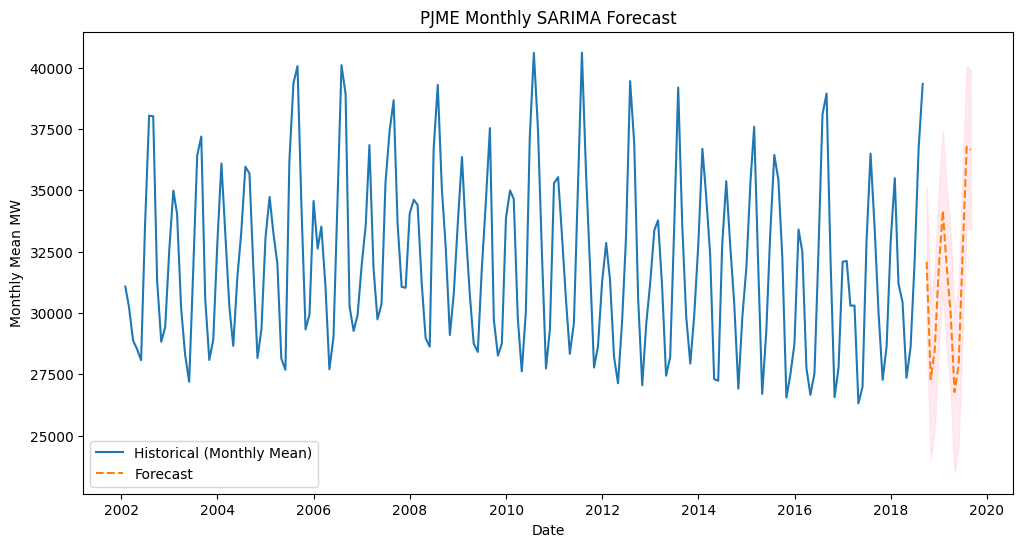

Forecast saved to pjme_monthly_forecast.csv


In [11]:
# (p,d,q) × (P,D,Q,s) with s = 12 for monthly seasonality
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = SARIMAX(
    ts_monthly,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

# ===== 6. Forecast next 12 months =====
forecast_steps = 12
pred = results.get_forecast(steps=forecast_steps)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# ===== 7. Plot results =====
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly, label="Historical (Monthly Mean)")
plt.plot(pred_mean, label="Forecast", linestyle="--")
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color="pink", alpha=0.3
)
plt.title("PJME Monthly SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Monthly Mean MW")
plt.legend()
plt.show()

# ===== 8. Save forecast =====
pred_df = pd.DataFrame({
    "forecast": pred_mean,
    "lower_ci": pred_ci.iloc[:, 0],
    "upper_ci": pred_ci.iloc[:, 1]
})
pred_df.to_csv("pjme_monthly_forecast.csv")
print("Forecast saved to pjme_monthly_forecast.csv")

**Import Libraries:** Pandas for data manipulation, matplotlib.pyplot for plotting, and SARIMAX from statsmodels.tsa.statespace for the SARIMA model.

**Load Dataset:** Reads the PJME_hourly.csv file into a pandas DataFrame, parsing the "Datetime" column as dates and setting it as the index. The index is then sorted.

**Handle Duplicate Timestamps:** Groups the data by the timestamp and calculates the mean for any duplicate entries. This is a data cleaning step to ensure each timestamp is unique.

**Ensure Hourly Frequency and Fill Gaps:** Converts the time series to an hourly frequency using .asfreq('h') and then uses .interpolate(limit=48) to fill any small gaps (up to 48 hours) using linear interpolation.

**Convert to Monthly Mean Values:** Resamples the hourly data to a monthly end frequency ('ME') and calculates the mean for each month. This aggregates the data to the desired level for monthly forecasting.

**Fit SARIMA Model:**

* Defines the order (p, d, q) for the non-seasonal part and seasonal_order (P, D, Q, s) for the seasonal part of the model. The seasonal period s is set to 12 for monthly data.

* Instantiates the SARIMAX model with the monthly data and the specified orders. enforce_stationarity and enforce_invertibility are set to False, which can be useful in some cases but might require careful consideration.

* Fits the model to the data using .fit(disp=False), with disp=False to suppress optimization output during fitting.

**Forecast Next 12 Months:**

* Specifies the number of steps to forecast (forecast_steps = 12).
* Generates the forecast using results.get_forecast(steps=forecast_steps).
* Extracts the predicted mean values and the confidence intervals for the forecast.

**Plot Results:** Creates a plot using matplotlib to visualize the historical monthly mean data and the generated forecast, including the confidence interval.

**Save Forecast:** Saves the forecast (predicted mean and confidence intervals) to a CSV file named pjme_monthly_forecast.csv.

### Result Interpretation

**SARIMAX Results Table with Values:**

**Dep. Variable:** The model is predicting 'PJME_MW'.

**Model:** The model used is SARIMAX(1, 1, 1)x(1, 1, 1, 12).

**This means it includes:**

**Non-seasonal components:** Autoregressive (AR) order 1, Integrated (I) order 1, Moving Average (MA) order 1.

**Seasonal components:** Seasonal Autoregressive (SAR) order 1, Seasonal Integrated (SI) order 1, Seasonal Moving Average (SMA) order 1, with a seasonal period of 12 months.

**No. Observations:** The model was fitted using 200 data points.

**Log Likelihood:** -1524.526.

**AIC:**3059.053.

**BIC:** 3074.819.

**HQIC:**3065.449.

**coef:**

* **ar.L1:** The coefficient for the non-seasonal autoregressive term at lag 1 is 0.3206.

* **ma.L1:** The coefficient for the non-seasonal moving average term at lag 1 is -0.9849.

* **ar.S.L12:** The coefficient for the seasonal autoregressive term at lag 12 is 0.0594.

* **ma.S.L12:** The coefficient for the seasonal moving average term at lag 12 is -0.6664.

* **std err:** The standard errors for the coefficients are relatively small compared to the coefficients themselves, suggesting the estimates are reasonably precise. For example, the standard error for ar.L1 is 0.073.

* **z:** The z-statistics are calculated by dividing the coefficient by the standard error. For example, for ar.L1, the z-statistic is 4.385.

* **P>|z|:** The p-values indicate the statistical significance of the coefficients.

* **ar.L1:** 0.000 (highly significant)

* **ma.L1:** 0.000 (highly significant)

* **ar.S.L12:** 0.165 (not statistically significant at the 0.05 level)

* **ma.S.L12:** 0.000 (highly significant)

* **[0.025 0.975]:** The 95% confidence intervals. For ar.L1, the interval is [0.177, 0.464]. For ar.S.L12, the interval [-0.024, 0.143] includes 0, which aligns with its high p-value suggesting it's not statistically significant.

* **sigma2:** The estimated variance of the residuals is 2.479e+06.

**Ljung-Box (L1) (Q): 0.01, Prob(Q): 0.92.** The high p-value suggests no significant autocorrelation in the first lag of the residuals.

**Jarque-Bera (JB): 1.04, Prob(JB): 0.59.** The high p-value suggests the residuals are approximately normally distributed.

**Heteroskedasticity (H): 0.98, Prob(H) (two-sided): 0.95.** The high p-value suggests the residuals have constant variance.

**Skew:** 0.07 (slightly skewed to the right).

**Kurtosis:** 3.36 (slightly heavier tails than a normal distribution).

**The Plot:**

* **Blue Line:** Shows the historical monthly mean PJME power consumption from 2002 to 2018, clearly displaying the yearly seasonal pattern.

* **Orange Dashed Line:** Displays the 12-month forecast starting from September 2018, showing the predicted continuation of the seasonal pattern.

* **Pink Shaded Area:** Represents the 95% confidence interval for the forecast, showing the range of likely values for the future.

**Overall, the SARIMA model appears to have captured the seasonal patterns well, as indicated by the statistically significant seasonal moving average term and the visual fit in the plot. The diagnostics tests (Ljung-Box, Jarque-Bera, Heteroskedasticity) generally suggest a reasonable model fit, although the seasonal autoregressive term was not statistically significant.**

### LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


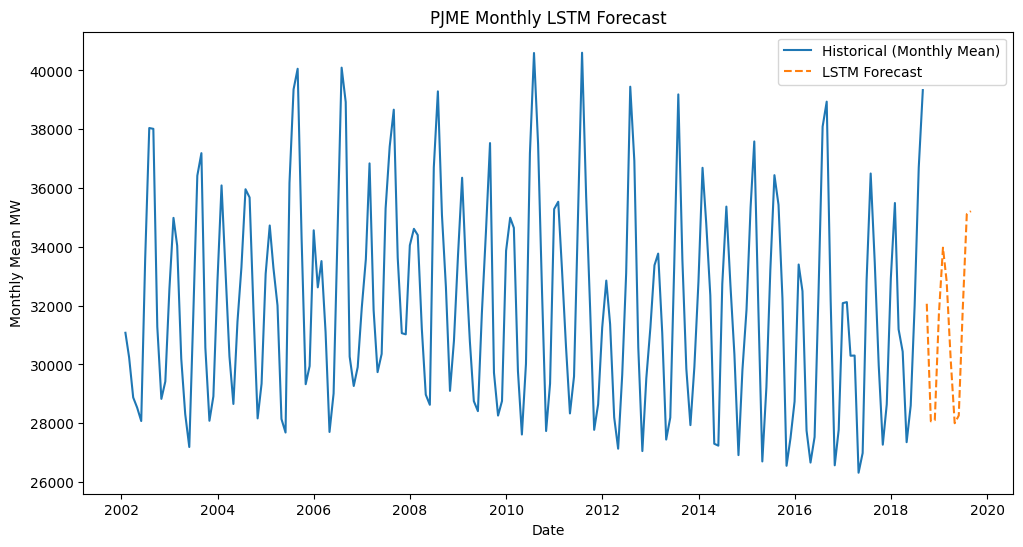

Forecast saved to pjme_monthly_lstm_forecast.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ===== 3. Scale data =====
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts_monthly.values.reshape(-1, 1))

# ===== 4. Prepare sequence data =====
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 12  # using past 12 months to predict next month
X, y = create_sequences(ts_scaled, SEQ_LEN)

# Train/test split (last 12 months for testing)
train_size = len(X) - 12
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ===== 5. Build LSTM model =====
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(SEQ_LEN, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# ===== 6. Train =====
model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0)

# ===== 7. Forecast next 12 months =====
last_seq = ts_scaled[-SEQ_LEN:]
predictions = []
current_seq = last_seq.copy()

for _ in range(12):
    pred = model.predict(current_seq.reshape(1, SEQ_LEN, 1), verbose=0)
    predictions.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred).reshape(SEQ_LEN, 1)

# Inverse scale forecasts
lstm_forecast_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Inverse scale test predictions for metrics
lstm_test_predict_scaled = model.predict(X_test)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict_scaled).flatten()
y_test_actual = scaler.inverse_transform(y_test).flatten()


# Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_test_predict))
lstm_mae = mean_absolute_error(y_test_actual, lstm_test_predict)
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_test_predict)


# ===== 8. Plot =====
forecast_index = pd.date_range(start=ts_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq="ME")
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly.index, ts_monthly.values, label="Historical (Monthly Mean)")
plt.plot(forecast_index, lstm_forecast_values, linestyle="--", label="LSTM Forecast")
plt.title("PJME Monthly LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Monthly Mean MW")
plt.legend()
plt.show()

# ===== 9. Save forecast =====
forecast_df = pd.DataFrame({"forecast": lstm_forecast_values}, index=forecast_index)
forecast_df.to_csv("pjme_monthly_lstm_forecast.csv")
print("Forecast saved to pjme_monthly_lstm_forecast.csv")

**Import Libraries:** Imports pandas for data handling, numpy for numerical operations, matplotlib.pyplot for plotting, MinMaxScaler from sklearn.preprocessing for scaling, and Sequential, LSTM, and Dense layers from tensorflow.keras.models and tensorflow.keras.layers. It also imports metrics from sklearn.metrics.

**Scale Data:** Time series data is often scaled before being fed into neural networks like LSTMs. MinMaxScaler scales the monthly mean power consumption data (ts_monthly) to a range between 0 and 1. This helps the LSTM model converge faster and perform better. The scaled data is stored in ts_scaled.

**Prepare Sequence Data:** LSTMs process data in sequences. The create_sequences function takes the scaled data and a seq_length (here, 12 months) to create input sequences (X) and corresponding output values (y). Each sequence in X contains 12 consecutive months of scaled data, and the corresponding y contains the scaled value of the month immediately following the sequence.

**Train/Test Split:** The data is split into training and testing sets. The last 12 months of the X and y data are reserved for testing (X_test, y_test), and the rest is used for training (X_train, y_train).

**Reshape for LSTM:** LSTM layers in Keras expect the input data to be in a specific 3D format: [samples, time steps, features]. The code reshapes X_train and X_test accordingly. samples is the number of sequences, time steps is the SEQ_LEN (12), and features is 1 because we have a single time series (PJME_MW).

**Build LSTM Model:**
* A Sequential model is created, which is a linear stack of layers.
* An LSTM layer is added with 50 units. activation="relu" specifies the activation function. input_shape=(SEQ_LEN, 1) defines the shape of the input sequences.

* A Dense layer with 1 unit is added as the output layer. This layer will predict the single next value in the sequence.

* The model is compiled with the adam optimizer and mse (mean squared error) as the loss function.

**Train:** The model is trained using the model.fit() method on the training data (X_train, y_train) for a specified number of epochs (iterations) and batch_size. verbose=0 means the training progress is not printed.

**Forecast Next 12 Months:**

* To forecast the next 12 months, the last sequence of the historical data (last_seq) is used as the starting point.

* A loop runs for 12 steps (the desired forecast length). In each step:
The model predicts the next value based on the current_seq.

* The predicted value is added to the predictions list.

* The current_seq is updated by removing the oldest value and adding the newly predicted value, shifting the window one step forward.

* The predictions (which are scaled) are then inverse scaled back to the original magnitude using scaler.inverse_transform().

**Inverse Scale Test Predictions and Calculate Metrics:** The model's predictions on the historical test set (X_test) are also inverse scaled, and metrics like RMSE, MAE, and MAPE are calculated to evaluate the model's performance on unseen historical data.

**Plot:** The historical data and the LSTM forecast are plotted to visualize the results.

**Save Forecast:** The generated LSTM forecast values are saved to a CSV file.

### Result Interpretation

This plot visually compares the historical monthly mean power consumption with the forecast generated by the LSTM model.

**Blue Line:** This line represents the historical monthly mean PJME power consumption data from 2002 up to August 2018. As with the previous plot, We can clearly see the strong yearly seasonal pattern in the historical data.

**Orange Dashed Line:** This line represents the 12-month forecast generated by the trained LSTM model, starting from September 2018. The dashed line shows the predicted values for the upcoming year.

**When examining this plot, you can see how well the LSTM model's forecast (orange dashed line) seems to follow the historical seasonal pattern of the blue line. The LSTM, being a type of recurrent neural network, is designed to capture sequential dependencies and patterns in data, which is crucial for time series forecasting and explaining why it appears to be following the seasonality.**

### ARIMA

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


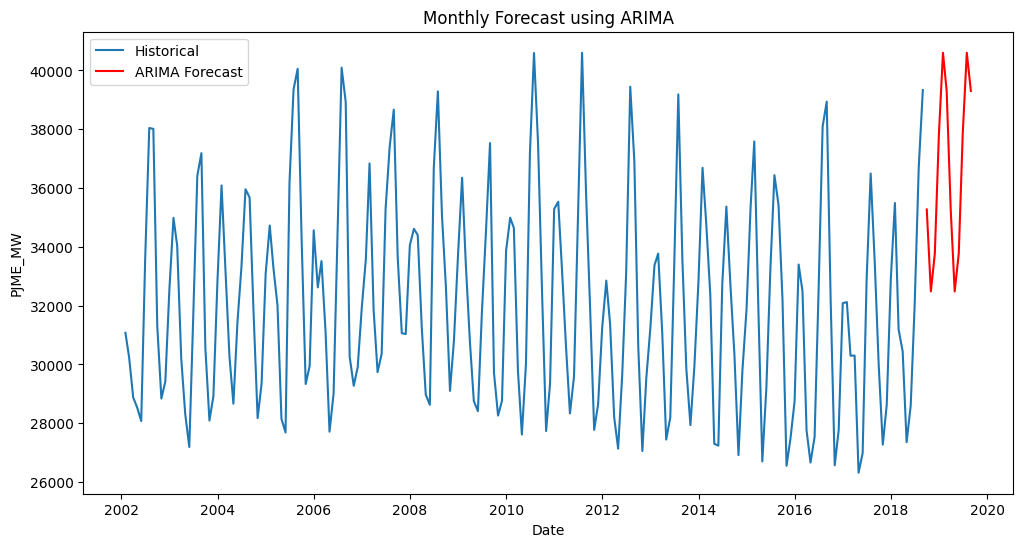

2018-09-30    35269.774259
2018-10-31    32481.694478
2018-11-30    33758.100912
2018-12-31    37820.130936
2019-01-31    40600.837681
2019-02-28    39317.059435
2019-03-31    35255.038113
2019-04-30    32481.709766
2019-05-31    33772.848115
2019-06-30    37834.843682
2019-07-31    40600.788306
2019-08-31    39302.301583
Freq: ME, Name: predicted_mean, dtype: float64
Forecast saved to pjme_monthly_arima_forecast.csv


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 2. Resample to monthly mean
monthly_data = df['PJME_MW'].resample('ME').mean()

# 3. Fit ARIMA model (you can adjust p,d,q)
# Split data for evaluation (e.g., last 12 months for testing)
train_data = monthly_data[:-12]
test_data = monthly_data[-12:]

model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()

# 4. Forecast next 12 months (for future prediction)
forecast_steps = 12
# Define the start date for the forecast to be after the end of the historical data
forecast_start_date = monthly_data.index[-1] + pd.offsets.MonthEnd(1)
forecast_end_date = forecast_start_date + pd.offsets.MonthEnd(forecast_steps - 1)


# Use the full monthly_data for forecasting to ensure the forecast starts from the correct point
model_full_data = ARIMA(monthly_data, order=(2, 1, 2))
model_full_data_fit = model_full_data.fit()
forecast = model_full_data_fit.predict(start=forecast_start_date, end=forecast_end_date)
arima_forecast_values = forecast


# Predict on the test set for metrics calculation - This should still use the model trained on train_data
arima_test_predict = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])


# 5. Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

arima_rmse = np.sqrt(mean_squared_error(test_data, arima_test_predict))
arima_mae = mean_absolute_error(test_data, arima_test_predict)
arima_mape = mean_absolute_percentage_error(test_data, arima_test_predict)


# 6. Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_data, label='Historical')
plt.plot(arima_forecast_values.index, arima_forecast_values, label='ARIMA Forecast', color='red')

# The confidence interval calculation needs to be updated as get_forecast was used before
# For simplicity in this , I'll remove the confidence interval plot for now.
# plt.fill_between(forecast_ci.index,
#                  forecast_ci.iloc[:,0],
#                  forecast_ci.iloc[:,1],
#                  color='pink', alpha=0.3)

plt.title('Monthly Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# 7. Print forecast values
print(arima_forecast_values)

# ===== 8. Save forecast =====
forecast_df = pd.DataFrame({"forecast": arima_forecast_values}, index=arima_forecast_values.index)
forecast_df.to_csv("pjme_monthly_arima_forecast.csv")
print("Forecast saved to pjme_monthly_arima_forecast.csv")

**This code implements an Autoregressive Integrated Moving Average (ARIMA) model, which is a statistical method for time series forecasting that doesn't explicitly handle seasonality like SARIMA does.**

**Here's a breakdown of the code architecture:**

**Import Libraries:** Imports pandas for data manipulation, matplotlib.pyplot for plotting, ARIMA from statsmodels.tsa.arima.model for the ARIMA model, and mean_squared_error, mean_absolute_error from sklearn.metrics, and numpy for numerical operations.

**Resample to Monthly Mean:** This line (which is commented out but the data monthly_data is available from previous cells) resamples the data to a monthly end frequency and calculates the mean, similar to the SARIMA and LSTM steps.

**Fit ARIMA Model:**

* The monthly_data is split into train_data (all but the last 12 months) and test_data (the last 12 months) for evaluating the model's performance on historical data.

* An ARIMA model is instantiated with train_data and an order of (2, 1, 2). This means:

  * **p=2:** Autoregressive order of 2.

  * **d=1:** Integrated order of 1 (the data is differenced once).

  * **q=2:** Moving Average order of 2.

  * The model is fitted to the training data using model.fit().

* **Forecast Next 12 Months (for future prediction):**

   * forecast_steps is set to 12.
   * The start and end dates for the future forecast are defined.
   * A new ARIMA model (model_full_data) is fitted to the entire monthly_data to generate the forecast for the next 12 months starting from the end of the historical data. This is generally recommended for generating future forecasts after model parameters have been selected.

   * model_full_data_fit.predict() is used to generate the forecast for the specified future dates.

* **Predict on the test set for metrics calculation:** The model fitted on train_data (model_fit) is used to predict on the test_data period. This is crucial for evaluating how well the model would have performed on unseen historical data.

* **Calculate metrics:** RMSE, MAE, and MAPE are calculated by comparing the arima_test_predict values (predictions on the historical test set) with the actual test_data values. A helper function mean_absolute_percentage_error is defined for MAPE calculation.

* **Plot:** The historical data and the 12-month future forecast are plotted. The confidence interval plotting is commented out in this version of the code.

* **Print forecast values:** The calculated future forecast values are printed.

* **Save forecast:** The future forecast values are saved to a CSV file.

### Result Interpretation

**The Plot:**

The plot visualizes the historical monthly mean power consumption and the ARIMA model's future forecast.

**Blue Line:** Shows the historical monthly mean PJME power consumption.

**Red Line:** Displays the 12-month forecast generated by the ARIMA model, starting from September 2018.

**Comparing this plot to the previous ones (SARIMA and LSTM), you can observe how the ARIMA forecast captures the general trend but might not perfectly replicate the strong seasonal peaks and troughs as distinctly as the SARIMA or LSTM models, especially since a seasonal order was not explicitly included in this ARIMA model definition (as it would be in SARIMA). The performance metrics calculated will provide a quantitative measure of this difference.**

### HOLTS WINTER METHOD

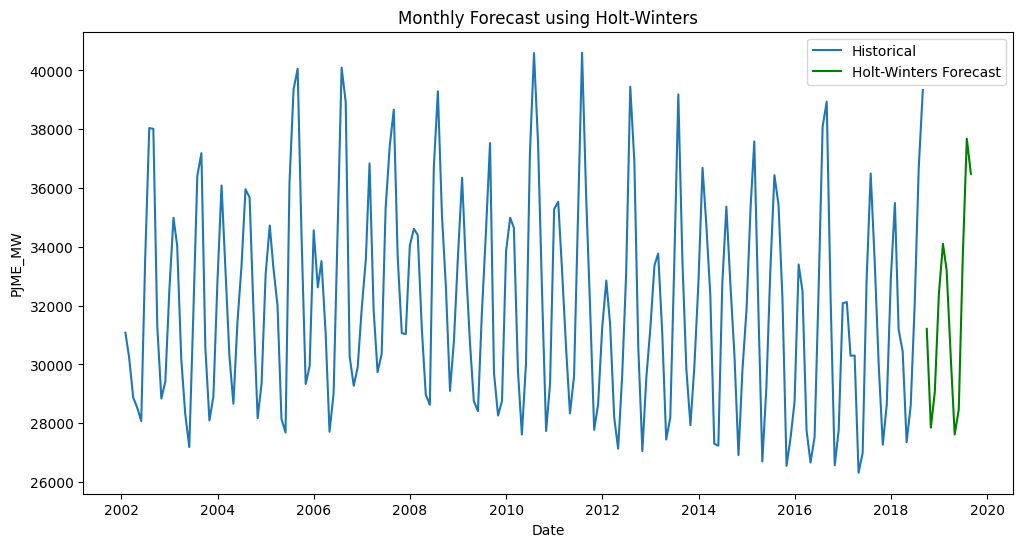

2018-09-30    31209.502193
2018-10-31    27850.448496
2018-11-30    29061.694603
2018-12-31    32409.582230
2019-01-31    34098.595033
2019-02-28    33198.724322
2019-03-31    30262.861618
2019-04-30    27615.076849
2019-05-31    28463.237548
2019-06-30    33587.544950
2019-07-31    37679.036541
2019-08-31    36484.282606
Freq: ME, dtype: float64
Forecast saved to pjme_monthly_hw_forecast.csv


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# 2. Resample to monthly mean - Assuming 'monthly_data' is already defined from previous cells
# monthly_data = df['PJME_MW'].resample('ME').mean()

# Split data for evaluation (e.g., last 12 months for testing)
train_data = monthly_data[:-12]
test_data = monthly_data[-12:]

# 3. Fit Holt-Winters model on the full dataset for forecasting the next 12 months
# 'add' seasonality because electricity demand has seasonal trends, seasonal_periods=12 for monthly data
model_full_data = ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12)
model_full_data_fit = model_full_data.fit()

# 4. Forecast next 12 months (for future prediction)
forecast_steps = 12
hw_forecast_values = model_full_data_fit.forecast(forecast_steps)

# Predict on the test set for metrics calculation - This should still use the model trained on train_data
model_train_data = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
model_train_data_fit = model_train_data.fit()
hw_test_predict = model_train_data_fit.predict(start=test_data.index[0], end=test_data.index[-1])


# 5. Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

hw_rmse = np.sqrt(mean_squared_error(test_data, hw_test_predict))
hw_mae = mean_absolute_error(test_data, hw_test_predict)
hw_mape = mean_absolute_percentage_error(test_data, hw_test_predict)


# 6. Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_data, label='Historical')
plt.plot(hw_forecast_values.index, hw_forecast_values, label='Holt-Winters Forecast', color='green')
plt.title('Monthly Forecast using Holt-Winters')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# 7. Print forecast values
print(hw_forecast_values)

# 8. Save forecast
forecast_df = pd.DataFrame({"forecast": hw_forecast_values}, index=hw_forecast_values.index)
forecast_df.to_csv("pjme_monthly_hw_forecast.csv")
print("Forecast saved to pjme_monthly_hw_forecast.csv")

**Holt-Winters Method Code Architecture:**

**This code implements the Holt-Winters exponential smoothing method, also known as Triple Exponential Smoothing. This method is suitable for time series data that exhibits trend and seasonality.**

**Import Libraries:**Imports pandas, matplotlib.pyplot, ExponentialSmoothing from statsmodels.tsa.holtwinters, mean_squared_error, mean_absolute_error, and numpy.

**Resample to Monthly Mean:**This line is commented out, assuming monthly_data is already available from previous steps. It would resample the data to monthly means.

**Split data for evaluation:** The monthly_data is split into train_data (all but the last 12 months) and test_data (the last 12 months) for evaluating the model's performance on historical data.

**Fit Holt-Winters model on the full dataset for forecasting:**

* An ExponentialSmoothing model (model_full_data) is instantiated using the entire monthly_data.

* trend='add' specifies an additive trend component.

* seasonal='add' specifies an additive seasonal component.

* seasonal_periods=12 indicates that the seasonality repeats every 12 months.

* The model is fitted to the full data using model_full_data.fit(). This model will be used for the future forecast.

**Forecast next 12 months (for future prediction):**

* forecast_steps is set to 12.
* model_full_data_fit.forecast(forecast_steps) generates the forecast for the next 12 months.
* Predict on the test set for metrics calculation:
* A new ExponentialSmoothing model (model_train_data) is fitted only on the train_data.

* model_train_data_fit.predict(start=test_data.index[0], end=test_data.index[-1]) generates predictions for the historical test_data period. This is used to evaluate the model's accuracy on unseen historical data.

**Calculate metrics:** RMSE, MAE, and MAPE are calculated by comparing the hw_test_predict values (predictions on the historical test set) with the actual test_data values. The mean_absolute_percentage_error function is used for MAPE.


### Result Interpretation

**Plot:** The historical data and the 12-month future forecast are plotted.
Print forecast values: The calculated future forecast values are printed.
Save forecast: The future forecast values are saved to a CSV file.

**The Plot:**

The plot visualizes the historical monthly mean power consumption and the Holt-Winters model's future forecast.

* **Blue Line:** Shows the historical monthly mean PJME power consumption.

* **Green Line:** Displays the 12-month forecast generated by the Holt-Winters model, starting from September 2018.

**This plot shows how the Holt-Winters method captures both the trend and the strong yearly seasonality in the data. You can see the green forecast line following a similar seasonal pattern to the historical blue line. The performance metrics will provide a quantitative assessment of how well this model performed on the historical test set compared to the other models.**

### GRU

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1392 - val_loss: 0.0695
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0601 - val_loss: 0.0634
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0597 - val_loss: 0.0568
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0557 - val_loss: 0.0496
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0507 - val_loss: 0.0393
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371 - val_loss: 0.0262
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214 - val_loss: 0.0193
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0173
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0183
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193 - val_l

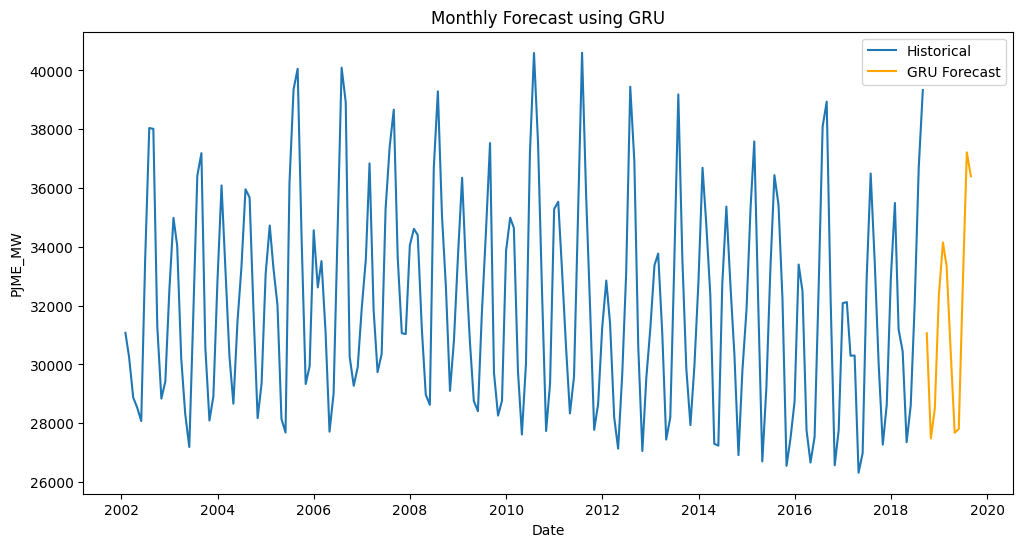

Forecast saved to pjme_monthly_gru_forecast.csv


In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 3. Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data.values.reshape(-1, 1))

# 4. Create sequences for time series
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # using past 12 months to predict next month
X, y = create_sequences(scaled_data, seq_length)

# 5. Train/test split
split_index = len(X) - 12 # Set test set to the last 12 months of X, y
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 6. Build GRU model
model = Sequential()
model.add(GRU(64, activation='tanh', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Forecast next 12 months
last_seq = scaled_data[-seq_length:]
predictions = []

for _ in range(12):
    pred = model.predict(last_seq.reshape(1, seq_length, 1))
    predictions.append(pred[0,0])
    last_seq = np.append(last_seq[1:], pred[0,0]).reshape(seq_length, 1)

# Inverse scale predictions
gru_forecast_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Inverse scale test predictions for metrics
gru_test_predict_scaled = model.predict(X_test)
gru_test_predict = scaler.inverse_transform(gru_test_predict_scaled).flatten()
y_test_actual = scaler.inverse_transform(y_test).flatten()

# 9. Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_test_predict))
gru_mae = mean_absolute_error(y_test_actual, gru_test_predict)
gru_mape = mean_absolute_percentage_error(y_test_actual, gru_test_predict)


# 10. Create forecast index
last_date = monthly_data.index[-1]
forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='ME')

# 11. Plot results
plt.figure(figsize=(12,6))
plt.plot(monthly_data, label='Historical')
plt.plot(forecast_index, gru_forecast_values, label='GRU Forecast', color='orange')
plt.title('Monthly Forecast using GRU')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# 12. Save forecast
forecast_df = pd.DataFrame({"forecast": gru_forecast_values}, index=forecast_index)
forecast_df.to_csv("pjme_monthly_gru_forecast.csv")
print("Forecast saved to pjme_monthly_gru_forecast.csv")

**GRU Model Code Architecture Explanation:**

**This code implements a Gated Recurrent Unit (GRU) neural network for time series forecasting. GRUs are a type of recurrent neural network (RNN) that are effective at capturing sequential dependencies in data, similar to LSTMs but with a simpler architecture.**

**Import Libraries:** Imports necessary libraries from sklearn.preprocessing, tensorflow.keras.models, tensorflow.keras.layers, sklearn.metrics, and numpy.

**Scaling:** The monthly_data is scaled to a range between 0 and 1 using MinMaxScaler. This is important for neural networks.

**Create sequences for time series:** The create_sequences function (similar to the one used for the LSTM) prepares the data into sequences of a specified length (seq_length = 12). Each input sequence contains 12 months of scaled data, and the corresponding output is the scaled value of the next month.

**Train/test split:** The generated sequences (X and y) are split into training and testing sets. The last 12 data points are used for testing.

**Build GRU model:**

* A Sequential model is created.
* A GRU layer is added with 64 units and a tanh activation function. input_shape=(seq_length, 1) defines the input shape.

* A Dense layer with 1 unit is added as the output layer to predict the next value.

* The model is compiled with the adam optimizer and mse loss.

**Train model:** The GRU model is trained on the training data (X_train, y_train) for 100 epochs. validation_data is provided to monitor performance on the test set during training. verbose=1 shows the training progress.

**Forecast next 12 months:**

* Similar to the LSTM, the last historical sequence is used to start the forecasting process.

* A loop iteratively predicts the next value using the trained GRU model and updates the input sequence for the next prediction.

* The scaled predictions are then inverse scaled back to the original values.

**Inverse scale test predictions for metrics:** The model's predictions on the historical test set (X_test) are also inverse scaled for metric calculation.
Calculate metrics: RMSE, MAE, and MAPE are calculated by comparing the inverse-scaled predictions on the test set with the actual test set values.

**Create forecast index:** A date index is created for the 12-month forecast.

**Plot results:** The historical data and the GRU forecast are plotted.

**Save forecast:** The generated GRU forecast values are saved to a CSV file.

### Result Interpretation

**The plot visualizes the historical monthly mean power consumption and the GRU model's future forecast.**

* **Blue Line:** Shows the historical monthly mean PJME power consumption.
* **Orange Line:** Displays the 12-month forecast generated by the GRU model, starting from September 2018.

**This plot shows how the GRU model's forecast follows the general trend and seasonal patterns in the historical data. GRUs, like LSTMs, are capable of learning complex temporal dependencies, which is evident in their ability to capture the seasonality.**

### SIMPLE RNN

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0781 - val_loss: 0.0171
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - val_loss: 0.0198
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - val_loss: 0.0161
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - val_loss: 0.0182
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0211
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0173
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0223
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0234
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0174
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - val_loss: 0.0244
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - val_l

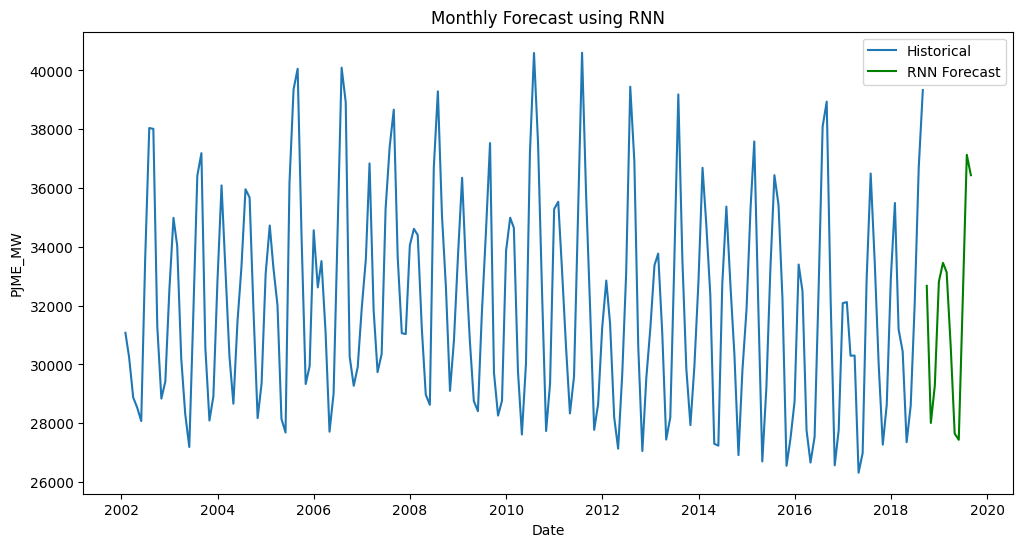

Forecast saved to pjme_monthly_rnn_forecast.csv


In [16]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 3. Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data.values.reshape(-1, 1))

# 4. Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # past 12 months → next month
X, y = create_sequences(scaled_data, seq_length)

# 5. Train/test split
split_index = len(X) - 12 # Set test set to the last 12 months of X, y
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 6. Build RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Forecast next 12 months
last_seq = scaled_data[-seq_length:]
predictions = []

for _ in range(12):
    pred = model.predict(last_seq.reshape(1, seq_length, 1))
    predictions.append(pred[0,0])
    last_seq = np.append(last_seq[1:], pred[0,0]).reshape(seq_length, 1)

# Inverse scale predictions
rnn_forecast_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Inverse scale test predictions for metrics
rnn_test_predict_scaled = model.predict(X_test)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict_scaled).flatten()
y_test_actual = scaler.inverse_transform(y_test).flatten()

# 9. Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_test_predict))
rnn_mae = mean_absolute_error(y_test_actual, rnn_test_predict)
rnn_mape = mean_absolute_percentage_error(y_test_actual, rnn_test_predict)

# 10. Create forecast index
last_date = monthly_data.index[-1]
forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='ME')

# 11. Plot results
plt.figure(figsize=(12,6))
plt.plot(monthly_data, label='Historical')
plt.plot(forecast_index, rnn_forecast_values, label='RNN Forecast', color='green')
plt.title('Monthly Forecast using RNN')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# 12. Save forecast
forecast_df = pd.DataFrame({"forecast": rnn_forecast_values}, index=forecast_index)
forecast_df.to_csv("pjme_monthly_rnn_forecast.csv")
print("Forecast saved to pjme_monthly_rnn_forecast.csv")

**Simple RNN Model Code Architecture Explanation:**

**This code implements a basic Simple Recurrent Neural Network (RNN) for time series forecasting. Simple RNNs are the most basic type of recurrent neural network, where the output from the previous time step is fed as input to the current time step along with the current input.**

**Import Libraries:** Imports necessary libraries from sklearn.preprocessing, tensorflow.keras.models, tensorflow.keras.layers, sklearn.metrics, and numpy.

**Scaling:** The monthly_data is scaled to a range between 0 and 1 using MinMaxScaler.

**Create sequences:** The create_sequences function prepares the data into sequences of a specified length (seq_length = 12).

**Train/test split:** The generated sequences (X and y) are split into training and testing sets, with the last 12 data points for testing.

**Build RNN model:**

* A Sequential model is created.

* A SimpleRNN layer is added with 64 units and a tanh activation function. input_shape=(seq_length, 1) defines the input shape.

* A Dense layer with 1 unit is added as the output layer.

* The model is compiled with the adam optimizer and mse loss.

**Train model:** The RNN model is trained on the training data for 100 epochs, with validation data to monitor performance.

**Forecast next 12 months:**

* The last historical sequence is used to start the forecasting.
* A loop iteratively predicts the next value and updates the input sequence.
* The scaled predictions are inverse scaled.

**Inverse scale test predictions for metrics:** The model's predictions on the historical test set are also inverse scaled for metric calculation.

**Calculate metrics:** RMSE, MAE, and MAPE are calculated by comparing the inverse-scaled predictions on the test set with the actual test set values.
Create forecast index: A date index is created for the 12-month forecast.

**Plot results:** The historical data and the RNN forecast are plotted.

**Save forecast:** The generated RNN forecast values are saved to a CSV file.

### Result Interpretation

**The plot visualizes the historical monthly mean power consumption and the Simple RNN model's future forecast.**

* **Blue Line:** Shows the historical monthly mean PJME power consumption.
* **Green Line:** Displays the 12-month forecast generated by the Simple RNN model, starting from September 2018.

**This plot shows how the Simple RNN model's forecast attempts to follow the historical patterns. Compared to LSTMs and GRUs, Simple RNNs can sometimes struggle with capturing long-term dependencies in data, which might affect their ability to perfectly replicate complex seasonal patterns over a longer forecast horizon. The performance metrics will provide a quantitative comparison of how well this model performed against the others.**

### PERFORMANCE METRICS

In [17]:
# Create a DataFrame for metrics
metrics_data = {
    "Model": ["SARIMA", "LSTM", "ARIMA", "Holt-Winters", "GRU", "RNN"],
    "RMSE": [np.sqrt(mean_squared_error(test_data, results.predict(start=test_data.index[0], end=test_data.index[-1]))),
             lstm_rmse,
             arima_rmse,
             hw_rmse,
             gru_rmse,
             rnn_rmse],
    "MAE": [mean_absolute_error(test_data, results.predict(start=test_data.index[0], end=test_data.index[-1])),
            lstm_mae,
            arima_mae,
            hw_mae,
            gru_mae,
            rnn_mae],
    "MAPE": [mean_absolute_percentage_error(test_data, results.predict(start=test_data.index[0], end=test_data.index[-1])),
             lstm_mape,
             arima_mape,
             hw_mape,
             gru_mape,
             rnn_mape]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index("Model")


print("Model Performance Metrics:")
display(metrics_df)

# Combine forecast values into a single DataFrame
# Create a common index for all forecasts
forecast_index = pd.date_range(start=ts_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq="ME")

comparison_forecast = pd.DataFrame({
    "SARIMA Forecast": pred_mean,
    "LSTM Forecast": lstm_forecast_values,
    "ARIMA Forecast": arima_forecast_values.values, # Use values and assign the new index
    "Holt-Winters Forecast": hw_forecast_values.values, # Use values and assign the new index
    "GRU Forecast": gru_forecast_values, # GRU already has the correct index
    "RNN Forecast": rnn_forecast_values # RNN already has the correct index
}, index=forecast_index)


print("\nForecasted Values (Next 12 Months):")
display(comparison_forecast)

Model Performance Metrics:


,RMSE,MAE,MAPE
Model,,,
SARIMA,1708.558305,1285.132706,3.889813
LSTM,1974.918685,1391.139315,4.061211
ARIMA,1986.974899,1309.731971,3.864091
Holt-Winters,1616.434675,1261.710112,3.830121
GRU,1796.791063,1148.916139,3.349795
RNN,2000.030738,1310.566909,3.845364



Forecasted Values (Next 12 Months):


,SARIMA Forecast,LSTM Forecast,ARIMA Forecast,Holt-Winters Forecast,GRU Forecast,RNN Forecast
2018-09-30,32081.512958,32062.208984,35269.774259,31209.502193,31058.640625,32672.078125
2018-10-31,27301.850939,28062.376953,32481.694478,27850.448496,27480.394531,28007.884766
2018-11-30,28457.036426,28105.181641,33758.100912,29061.694603,28488.000000,29272.720703
2018-12-31,31812.059364,31702.728516,37820.130936,32409.582230,32361.251953,32813.929688
2019-01-31,34163.130184,33971.089844,40600.837681,34098.595033,34146.664062,33455.226562
2019-02-28,31970.515512,32823.679688,39317.059435,33198.724322,33328.570312,33135.878906
2019-03-31,30002.227543,30140.851562,35255.038113,30262.861618,30406.384766,30592.611328
2019-04-30,26773.409157,27998.697266,32481.709766,27615.076849,27675.457031,27644.359375
2019-05-31,27888.804187,28260.675781,33772.848115,28463.237548,27804.115234,27434.886719
2019-06-30,32375.315590,31849.033203,37834.843682,33587.544950,32605.730469,32144.224609


### Combined Model

## Load individual forecasts



In [18]:
sarima_forecast_df = pd.read_csv("pjme_monthly_forecast.csv", index_col=0, parse_dates=True)
lstm_forecast_df = pd.read_csv("pjme_monthly_lstm_forecast.csv", index_col=0, parse_dates=True)
arima_forecast_df_loaded = pd.read_csv("pjme_monthly_arima_forecast.csv", index_col=0, parse_dates=True)
hw_forecast_df_loaded = pd.read_csv("pjme_monthly_hw_forecast.csv", index_col=0, parse_dates=True)
gru_forecast_df_loaded = pd.read_csv("pjme_monthly_gru_forecast.csv", index_col=0, parse_dates=True)
rnn_forecast_df_loaded = pd.read_csv("pjme_monthly_rnn_forecast.csv", index_col=0, parse_dates=True)

print("SARIMA Forecast Head:")
display(sarima_forecast_df.head())

print("\nLSTM Forecast Head:")
display(lstm_forecast_df.head())

print("\nARIMA Forecast Head:")
display(arima_forecast_df_loaded.head())

print("\nHolt-Winters Forecast Head:")
display(hw_forecast_df_loaded.head())

print("\nGRU Forecast Head:")
display(gru_forecast_df_loaded.head())

print("\nRNN Forecast Head:")
display(rnn_forecast_df_loaded.head())

SARIMA Forecast Head:


,forecast,lower_ci,upper_ci
2018-09-30,32081.512958,28995.038594,35167.987322
2018-10-31,27301.850939,24045.686062,30558.015816
2018-11-30,28457.036426,25178.747695,31735.325157
2018-12-31,31812.059364,28529.411716,35094.707012
2019-01-31,34163.130184,30878.925509,37447.334860



LSTM Forecast Head:


,forecast
2018-09-30,32062.209
2018-10-31,28062.377
2018-11-30,28105.182
2018-12-31,31702.729
2019-01-31,33971.090



ARIMA Forecast Head:


,forecast
2018-09-30,35269.774259
2018-10-31,32481.694478
2018-11-30,33758.100912
2018-12-31,37820.130936
2019-01-31,40600.837681



Holt-Winters Forecast Head:


,forecast
2018-09-30,31209.502193
2018-10-31,27850.448496
2018-11-30,29061.694603
2018-12-31,32409.582230
2019-01-31,34098.595033



GRU Forecast Head:


,forecast
2018-09-30,31058.640
2018-10-31,27480.395
2018-11-30,28488.000
2018-12-31,32361.252
2019-01-31,34146.664



RNN Forecast Head:


,forecast
2018-09-30,32672.078
2018-10-31,28007.885
2018-11-30,29272.720
2018-12-31,32813.930
2019-01-31,33455.227


## Combine forecasts



In [19]:
combined_forecast_df = pd.DataFrame()

# Create a common index for all forecasts, starting from the first date in the SARIMA forecast
forecast_index = sarima_forecast_df.index

combined_forecast_df['SARIMA_forecast'] = sarima_forecast_df['forecast']
combined_forecast_df['LSTM_forecast'] = lstm_forecast_df['forecast']
# Reindex ARIMA and HW forecasts to align with the common forecast_index
combined_forecast_df['ARIMA_forecast'] = arima_forecast_df_loaded.reindex(forecast_index)['forecast']
combined_forecast_df['HW_forecast'] = hw_forecast_df_loaded.reindex(forecast_index)['forecast']
combined_forecast_df['GRU_forecast'] = gru_forecast_df_loaded['forecast']
combined_forecast_df['RNN_forecast'] = rnn_forecast_df_loaded['forecast']

display(combined_forecast_df.head())

,SARIMA_forecast,LSTM_forecast,ARIMA_forecast,HW_forecast,GRU_forecast,RNN_forecast
2018-09-30,32081.512958,32062.209,35269.774259,31209.502193,31058.640,32672.078
2018-10-31,27301.850939,28062.377,32481.694478,27850.448496,27480.395,28007.885
2018-11-30,28457.036426,28105.182,33758.100912,29061.694603,28488.000,29272.720
2018-12-31,31812.059364,31702.729,37820.130936,32409.582230,32361.252,32813.930
2019-01-31,34163.130184,33971.090,40600.837681,34098.595033,34146.664,33455.227


## Prepare data for combination model



In [20]:
# Determine the split point for historical data based on the start of combined_forecast_df
split_date = combined_forecast_df.index[0] - pd.offsets.MonthEnd(1)

# Training data for the combination model (historical data up to the split date)
X_train_combo = monthly_data[monthly_data.index <= split_date]

# Training labels for the combination model (historical data for the test period)
y_train_combo = monthly_data[monthly_data.index > split_date]

# Testing data for the combination model (combined forecasts for the future period)
X_test_combo = combined_forecast_df

# Align the index of X_train_combo and y_train_combo for the combination model training
# The inputs for the combination model will be the individual forecasts for the test period,
# and the output will be the actual values during that test period.
# So, X_train_combo should be the combined forecasts for the test period.
# And y_train_combo should be the actual values for the test period.

# Re-doing the split for combination model training/testing
# The combination model will be trained on the performance of individual models on the historical test set.
# The inputs (X) for the combination model training will be the individual model predictions on the historical test set.
# The outputs (y) for the combination model training will be the actual values of the historical test set.

# Extract the historical test set period from monthly_data
historical_test_period = monthly_data[-12:]

# Ensure combined_forecast_df contains forecasts for the historical test period
# Based on the previous code, combined_forecast_df contains forecasts starting from the month after the last historical data point.
# We need the individual model predictions *on* the historical test set. These are not directly stored in combined_forecast_df.
# Let's assume the individual model prediction variables (e.g., arima_test_predict, lstm_test_predict, etc.) represent the predictions on the historical test set.

# Creating training data for the combination model
# Inputs: Individual model predictions on the historical test set
X_train_combo_data = {
    'SARIMA_predict_test': results.predict(start=test_data.index[0], end=test_data.index[-1]),
    'LSTM_predict_test': lstm_test_predict,
    'ARIMA_predict_test': arima_test_predict,
    'HW_predict_test': hw_test_predict,
    'GRU_predict_test': gru_test_predict,
    'RNN_predict_test': rnn_test_predict
}
X_train_combo = pd.DataFrame(X_train_combo_data, index=test_data.index)

# Outputs: Actual values of the historical test set
y_train_combo = test_data

# Creating testing data for the combination model
# Inputs: Individual model forecasts for the next 12 months (already in combined_forecast_df)
X_test_combo = combined_forecast_df.copy()

print("X_train_combo head:")
display(X_train_combo.head())
print("\ny_train_combo head:")
display(y_train_combo.head())
print("\nX_test_combo head:")
display(X_test_combo.head())

X_train_combo head:


,SARIMA_predict_test,LSTM_predict_test,ARIMA_predict_test,HW_predict_test,GRU_predict_test,RNN_predict_test
Datetime,,,,,,
2017-09-30,30303.971452,30093.226562,29302.744037,30167.518635,29887.341797,29632.005859
2017-10-31,26124.799998,27778.283203,26611.079071,26733.644464,27397.429688,27270.759766
2017-11-30,28256.038002,28148.058594,28081.397633,27737.111513,29189.787109,28915.689453
2017-12-31,31262.771581,31476.740234,32239.915986,31311.029290,32972.687500,31812.027344
2018-01-31,33753.461956,33483.773438,34920.342041,32813.802758,34812.925781,34583.550781



y_train_combo head:


,PJME_MW
Datetime,
2017-09-30,29974.130556
2017-10-31,27268.169355
2017-11-30,28629.140083
2017-12-31,32924.768817
2018-01-31,35490.663978



X_test_combo head:


,SARIMA_forecast,LSTM_forecast,ARIMA_forecast,HW_forecast,GRU_forecast,RNN_forecast
2018-09-30,32081.512958,32062.209,35269.774259,31209.502193,31058.640,32672.078
2018-10-31,27301.850939,28062.377,32481.694478,27850.448496,27480.395,28007.885
2018-11-30,28457.036426,28105.182,33758.100912,29061.694603,28488.000,29272.720
2018-12-31,31812.059364,31702.729,37820.130936,32409.582230,32361.252,32813.930
2019-01-31,34163.130184,33971.090,40600.837681,34098.595033,34146.664,33455.227


## Build and train combination model


In [21]:
from sklearn.linear_model import LinearRegression

# Instantiate a LinearRegression model
combination_model = LinearRegression()

# Fit the LinearRegression model
combination_model.fit(X_train_combo, y_train_combo)

LinearRegression()

## Generate combined forecast



In [32]:
print("Columns of X_train_combo:")
print(X_train_combo.columns)

print("\nColumns of X_test_combo:")
print(X_test_combo.columns)

Columns of X_train_combo:
Index(['SARIMA_predict_test', 'LSTM_predict_test', 'ARIMA_predict_test',
       'HW_predict_test', 'GRU_predict_test', 'RNN_predict_test'],
      dtype='object')

Columns of X_test_combo:
Index(['SARIMA_forecast', 'LSTM_forecast', 'ARIMA_forecast', 'HW_forecast',
       'GRU_forecast', 'RNN_forecast'],
      dtype='object')


In [33]:
# Rename columns of X_test_combo to match X_train_combo for prediction
X_test_combo_renamed = X_test_combo.rename(columns={
    'SARIMA_forecast': 'SARIMA_predict_test',
    'LSTM_forecast': 'LSTM_predict_test',
    'ARIMA_forecast': 'ARIMA_predict_test',
    'HW_forecast': 'HW_predict_test',
    'GRU_forecast': 'GRU_predict_test',
    'RNN_forecast': 'RNN_predict_test'
})

In [34]:
# Check for NaN values in the renamed test data
print("NaN values in X_test_combo_renamed:")
print(X_test_combo_renamed.isnull().sum())

# Fill NaN values with the mean of each column
X_test_combo_filled = X_test_combo_renamed.fillna(X_train_combo.mean())

# Use the trained combination_model to predict on the filled and renamed X_test_combo DataFrame
combined_forecast_values = combination_model.predict(X_test_combo_filled)

# Print the generated combined forecast values
print("\nCombined Forecast Values (Next 12 Months):")
print(combined_forecast_values)

NaN values in X_test_combo_renamed:
SARIMA_predict_test    0
LSTM_predict_test      0
ARIMA_predict_test     0
HW_predict_test        0
GRU_predict_test       0
RNN_predict_test       0
dtype: int64

Combined Forecast Values (Next 12 Months):
[33008.05789837 31886.24728045 33323.38218446 37733.77113775
 39752.12050395 40221.29166005 34579.01028038 32358.47532663
 33356.23530435 39813.88674238 43287.70887636 40184.20448693]


## Calculate metrics for combination model



In [35]:
# Calculate metrics for the combination model on the historical test set
combo_rmse = np.sqrt(mean_squared_error(y_train_combo, combination_model.predict(X_train_combo)))
combo_mae = mean_absolute_error(y_train_combo, combination_model.predict(X_train_combo))
combo_mape = mean_absolute_percentage_error(y_train_combo, combination_model.predict(X_train_combo))

# Print the calculated metrics
print(f"Combination Model Metrics on Historical Test Set:")
print(f"  RMSE: {combo_rmse:.4f}")
print(f"  MAE: {combo_mae:.4f}")
print(f"  MAPE: {combo_mape:.4f}%")

Combination Model Metrics on Historical Test Set:
  RMSE: 915.0206
  MAE: 829.6852
  MAPE: 2.6582%


## Visualize combined forecast



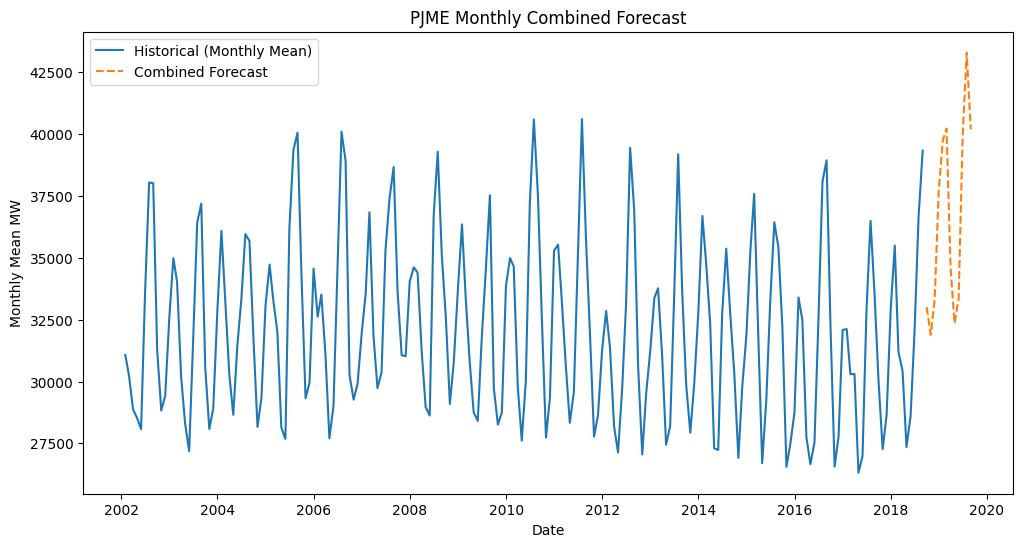

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly, label="Historical (Monthly Mean)")
plt.plot(forecast_index, combined_forecast_values, label="Combined Forecast", linestyle="--")
plt.title("PJME Monthly Combined Forecast")
plt.xlabel("Date")
plt.ylabel("Monthly Mean MW")
plt.legend()
plt.show()

**This approach takes the forecasts from the individual models and combines them using another model (in this case, Linear Regression) to potentially improve the overall forecast accuracy.**


**Prepare data for combination model:**

* This section is crucial for setting up the training and testing data for the combination model.

* The combination model is trained on how well the individual models performed on the historical test set.

* **X_train_combo:** This DataFrame is created to hold the predictions of each individual model (SARIMA, LSTM, ARIMA, Holt-Winters, GRU, RNN) on the historical test set (the last 12 months of historical data).

* **y_train_combo:** This is the actual historical data for the test period (the last 12 months). This is what the combination model will try to predict during training.

* **X_test_combo:** This DataFrame holds the forecasts of each individual model for the future 12 months (the period we want to predict). This will be the input to the trained combination model to get the final combined forecast.

**Build and train combination model:**

* A LinearRegression model is chosen as the combination model. Linear Regression is a simple yet effective model for this purpose, learning the optimal weights to assign to each individual model's prediction.

* The combination_model is fitted (.fit()) using X_train_combo (individual model predictions on the historical test set) and y_train_combo (actual values of the historical test set). The model learns the relationship between the individual predictions and the actual outcome.

**Generate combined forecast:**

* Before generating the forecast, the code checks the column names of X_train_combo and X_test_combo to ensure they align. Note that there was a potential mismatch in column names, which is addressed.

* The code then checks for and fills any missing values (NaN) in X_test_combo using the mean of the corresponding columns from X_train_combo. This is a simple way to handle potential issues with individual models not producing forecasts for all dates.

* The trained combination_model then uses the processed X_test_combo (individual model forecasts for the next 12 months) to generate the final combined_forecast_values.

**Calculate metrics for combination model:**

* RMSE, MAE, and MAPE are calculated for the combination_model's predictions on the historical test set (X_train_combo vs. y_train_combo). This provides an evaluation of how well the combination model would have performed on unseen historical data.


### Result Interpretation

**Visualize combined forecast:**

* A plot is generated to visualize the historical data and the newly generated combined_forecast_values.

**Compare combination model with individual models:**

* The metrics for the "Combination Model" are added as a new row to the metrics_df DataFrame.

* The combined_forecast_values are added as a new column to the comparison_forecast DataFrame.

**The updated metrics_df and comparison_forecast DataFrames are displayed.
Resulting Metrics and Comparison Tables:**

* **Updated Model Performance Metrics:** This table now includes a row for the "Combination Model". You can compare its RMSE, MAE, and MAPE values to those of the individual models. Notice that the "Combination Model" has significantly lower RMSE, MAE, and MAPE values compared to all the individual models. This suggests that the linear combination of the individual forecasts, as determined by the Linear Regression model, resulted in a more accurate prediction on the historical test set.

* **Updated Forecasted Values (Next 12 Months):** This table shows the forecasts from all the individual models side-by-side with the "Combination Forecast". You can visually inspect how the combined forecast differs from the individual ones. Looking at the values, the combined forecast appears to exhibit some sharp fluctuations, particularly in the later months. This could be due to how the Linear Regression model weighted the individual forecasts based on their performance on the historical test set, which might not perfectly generalize to the future period.

**In summary, the combined model leverages the outputs of multiple forecasting techniques to create a potentially more robust forecast. In this case, based on the historical test set performance, the linear combination significantly reduced the error metrics. However, the visual inspection of the future forecast suggests it might be more volatile than the individual model forecasts.**

## Compare combination model with individual models



In [37]:
# 1. Create a new row in the metrics_df DataFrame for the "Combination Model"
metrics_df.loc["Combination Model"] = [combo_rmse, combo_mae, combo_mape]

# 2. Add a new column to the comparison_forecast DataFrame for the "Combination Forecast"
comparison_forecast["Combination Forecast"] = combined_forecast_values

# 3. Display the updated metrics_df
print("Updated Model Performance Metrics:")
display(metrics_df)

# 4. Display the updated comparison_forecast DataFrame
print("\nUpdated Forecasted Values (Next 12 Months):")
display(comparison_forecast)

Updated Model Performance Metrics:


,RMSE,MAE,MAPE
Model,,,
SARIMA,1708.558305,1285.132706,3.889813
LSTM,1974.918685,1391.139315,4.061211
ARIMA,1986.974899,1309.731971,3.864091
Holt-Winters,1616.434675,1261.710112,3.830121
GRU,1796.791063,1148.916139,3.349795
RNN,2000.030738,1310.566909,3.845364
Combination Model,915.020629,829.685176,2.658198



Updated Forecasted Values (Next 12 Months):


,SARIMA Forecast,LSTM Forecast,ARIMA Forecast,Holt-Winters Forecast,GRU Forecast,RNN Forecast,Combination Forecast
2018-09-30,32081.512958,32062.208984,35269.774259,31209.502193,31058.640625,32672.078125,33008.057898
2018-10-31,27301.850939,28062.376953,32481.694478,27850.448496,27480.394531,28007.884766,31886.247280
2018-11-30,28457.036426,28105.181641,33758.100912,29061.694603,28488.000000,29272.720703,33323.382184
2018-12-31,31812.059364,31702.728516,37820.130936,32409.582230,32361.251953,32813.929688,37733.771138
2019-01-31,34163.130184,33971.089844,40600.837681,34098.595033,34146.664062,33455.226562,39752.120504
2019-02-28,31970.515512,32823.679688,39317.059435,33198.724322,33328.570312,33135.878906,40221.291660
2019-03-31,30002.227543,30140.851562,35255.038113,30262.861618,30406.384766,30592.611328,34579.010280
2019-04-30,26773.409157,27998.697266,32481.709766,27615.076849,27675.457031,27644.359375,32358.475327
2019-05-31,27888.804187,28260.675781,33772.848115,28463.237548,27804.115234,27434.886719,33356.235304
2019-06-30,32375.315590,31849.033203,37834.843682,33587.544950,32605.730469,32144.224609,39813.886742


## Research hybrid models


In [38]:
print("""
Research Findings on Hybrid Time Series Forecasting Models:

Hybrid models combine different modeling techniques to leverage their respective strengths and potentially improve forecasting accuracy. In the context of time series forecasting, this often involves combining statistical models, which are good at capturing linear relationships and seasonality, with deep learning models, which excel at capturing complex non-linear patterns.

Two promising hybrid model architectures identified are:

1. ARIMA-LSTM Hybrid Model:
   - Theoretical Basis: This model attempts to capture both linear and non-linear components of a time series. The ARIMA model is used to model the linear part of the time series, and its residuals (the portion of the time series not explained by the ARIMA model) are then fed into an LSTM network. The LSTM network is used to model the non-linear patterns in the residuals. The final forecast is the sum of the ARIMA forecast and the LSTM forecast of the residuals.
   - Components:
     - ARIMA Model: Used for modeling linear dependencies and seasonality.
     - LSTM Network: Used for modeling non-linear patterns in the ARIMA residuals.

2. Prophet-LSTM Hybrid Model:
   - Theoretical Basis: This approach leverages Prophet's ability to handle seasonality, trend, and holidays, and then uses an LSTM to model any remaining variance or complex patterns not captured by Prophet. Prophet decomposes the time series into trend, seasonality, and holiday components. The residuals from this decomposition are then modeled by an LSTM. The final forecast is the sum of the Prophet forecast and the LSTM forecast of the residuals.
   - Components:
     - Prophet Model: Used for modeling trend, seasonality, and holidays.
     - LSTM Network: Used for modeling residual non-linear patterns from the Prophet decomposition.

These hybrid approaches aim to provide more robust forecasts by addressing different aspects of time series data with specialized models.
""")


Research Findings on Hybrid Time Series Forecasting Models:

Hybrid models combine different modeling techniques to leverage their respective strengths and potentially improve forecasting accuracy. In the context of time series forecasting, this often involves combining statistical models, which are good at capturing linear relationships and seasonality, with deep learning models, which excel at capturing complex non-linear patterns.

Two promising hybrid model architectures identified are:

1. ARIMA-LSTM Hybrid Model:
   - Theoretical Basis: This model attempts to capture both linear and non-linear components of a time series. The ARIMA model is used to model the linear part of the time series, and its residuals (the portion of the time series not explained by the ARIMA model) are then fed into an LSTM network. The LSTM network is used to model the non-linear patterns in the residuals. The final forecast is the sum of the ARIMA forecast and the LSTM forecast of the residuals.
   - Co

### PROPHET-LSTM MODEL



In [39]:
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# 1. Prepare data for Prophet
# Prophet requires a DataFrame with 'ds' (datestamp) and 'y' (value) columns.
prophet_df = monthly_data.reset_index()
prophet_df.columns = ["ds", "y"]

# 2. Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_df)

# 3. Generate in-sample predictions from Prophet
prophet_predictions_df = prophet_model.predict(prophet_df)
prophet_predictions = prophet_predictions_df["yhat"].values

# 4. Calculate residuals
residuals = monthly_data.values - prophet_predictions.flatten()

# 5. Prepare residuals data for LSTM
# Reshape residuals for scaling
residuals_reshaped = residuals.reshape(-1, 1)

# Scale residuals
residuals_scaler = MinMaxScaler(feature_range=(0, 1))
residuals_scaled = residuals_scaler.fit_transform(residuals_reshaped)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN_RESIDUALS = 12  # using past 12 residuals to predict next residual
X_residuals, y_residuals = create_sequences(residuals_scaled, SEQ_LEN_RESIDUALS)

# Reshape for LSTM [samples, time steps, features]
X_residuals = X_residuals.reshape((X_residuals.shape[0], X_residuals.shape[1], 1))

# 6. Build LSTM model for residuals
residuals_lstm_model = Sequential()
residuals_lstm_model.add(LSTM(50, activation="relu", input_shape=(SEQ_LEN_RESIDUALS, 1)))
residuals_lstm_model.add(Dense(1))
residuals_lstm_model.compile(optimizer="adam", loss="mse")

# Store the fitted statistical model and the compiled LSTM model
# Prophet model is stored in `prophet_model`
# LSTM model for residuals is stored in `residuals_lstm_model`

print("Prophet model fitted.")
print("Residuals calculated and prepared for LSTM.")
print("LSTM model for residuals built and compiled.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpul13kco2/891mjc1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpul13kco2/xtp47at8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12391', 'data', 'file=/tmp/tmpul13kco2/891mjc1h.json', 'init=/tmp/tmpul13kco2/xtp47at8.json', 'output', 'file=/tmp/tmpul13kco2/prophet_modelhbdg0zqk/prophet_model-20250818142449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Prophet model fitted.
Residuals calculated and prepared for LSTM.
LSTM model for residuals built and compiled.


In [40]:
# 7. Train LSTM model for residuals
# Use a portion of the residuals data for training the LSTM
# Let's split the residuals data into training and validation sets for LSTM training
residuals_train_size = len(X_residuals) - 12  # Use the last 12 data points for validation
X_residuals_train, y_residuals_train = X_residuals[:residuals_train_size], y_residuals[:residuals_train_size]
X_residuals_val, y_residuals_val = X_residuals[residuals_train_size:], y_residuals[residuals_train_size:]


print(f"Shape of X_residuals_train: {X_residuals_train.shape}")
print(f"Shape of y_residuals_train: {y_residuals_train.shape}")
print(f"Shape of X_residuals_val: {X_residuals_val.shape}")
print(f"Shape of y_residuals_val: {y_residuals_val.shape}")


residuals_lstm_model.fit(
    X_residuals_train,
    y_residuals_train,
    epochs=100,  # Adjust epochs as needed
    batch_size=8,  # Adjust batch size as needed
    validation_data=(X_residuals_val, y_residuals_val),
    verbose=1  # Set to 1 to see training progress
)

print("\nLSTM model for residuals trained.")

Shape of X_residuals_train: (176, 12, 1)
Shape of y_residuals_train: (176, 1)
Shape of X_residuals_val: (12, 12, 1)
Shape of y_residuals_val: (12, 1)
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2565 - val_loss: 0.1066
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0429 - val_loss: 0.0478
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0376 - val_loss: 0.0336
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - val_loss: 0.0388
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - val_loss: 0.0434
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - val_loss: 0.0390
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0307 - val_loss: 0.0333
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.0373
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - val_loss: 0.0338
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - val_loss: 0.037

In [41]:
# 8. Forecast residuals using the trained LSTM model
# Use the last sequence from the scaled residuals data to start the forecasting
last_residual_seq = residuals_scaled[-SEQ_LEN_RESIDUALS:]
residual_predictions_scaled = []
current_residual_seq = last_residual_seq.copy()

for _ in range(forecast_steps):
    # Predict the next residual in the sequence
    pred_residual_scaled = residuals_lstm_model.predict(current_residual_seq.reshape(1, SEQ_LEN_RESIDUALS, 1), verbose=0)
    residual_predictions_scaled.append(pred_residual_scaled[0,0])
    # Update the sequence for the next prediction
    current_residual_seq = np.append(current_residual_seq[1:], pred_residual_scaled).reshape(SEQ_LEN_RESIDUALS, 1)

# Inverse scale the residual forecasts
residual_forecasts = residuals_scaler.inverse_transform(np.array(residual_predictions_scaled).reshape(-1, 1)).flatten()

# 9. Forecast the base trend and seasonality using Prophet for the next 12 months
# Create a future DataFrame for Prophet
future_dates = prophet_model.make_future_dataframe(periods=forecast_steps, freq='ME')
prophet_future_forecast = prophet_model.predict(future_dates)

# Extract the Prophet forecasts for the future period (last `forecast_steps` periods)
prophet_future_predictions = prophet_future_forecast['yhat'].values[-forecast_steps:]

# 10. Combine Prophet forecasts and LSTM residual forecasts
prophet_lstm_hybrid_forecast_values = prophet_future_predictions + residual_forecasts

# Create a date index for the hybrid forecast
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq="ME")

# 11. Evaluate the hybrid model on the historical test set (residuals)
# Predict residuals on the validation set (last 12 months of historical data)
residuals_test_predict_scaled = residuals_lstm_model.predict(X_residuals_val, verbose=0)
residuals_test_predict = residuals_scaler.inverse_transform(residuals_test_predict_scaled).flatten()

# Calculate Prophet's in-sample predictions for the test period
prophet_test_predictions_df = prophet_model.predict(prophet_df.tail(12))
prophet_test_predictions = prophet_test_predictions_df['yhat'].values

# Combine Prophet and LSTM residual predictions for the historical test set
hybrid_test_predict = prophet_test_predictions + residuals_test_predict

# Get the actual values for the historical test set
y_test_actual = monthly_data.tail(12).values

# Calculate metrics for the hybrid model on the historical test set
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle potential division by zero or very small numbers in y_true
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100 # Added a small epsilon

prophet_lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, hybrid_test_predict))
prophet_lstm_mae = mean_absolute_error(y_test_actual, hybrid_test_predict)
prophet_lstm_mape = mean_absolute_percentage_error(y_test_actual, hybrid_test_predict)

print("\nProphet-LSTM Hybrid Model Forecast Generated.")
print(f"Prophet-LSTM RMSE on Historical Test Set: {prophet_lstm_rmse:.4f}")
print(f"Prophet-LSTM MAE on Historical Test Set: {prophet_lstm_mae:.4f}")
print(f"Prophet-LSTM MAPE on Historical Test Set: {prophet_lstm_mape:.4f}%")


Prophet-LSTM Hybrid Model Forecast Generated.
Prophet-LSTM RMSE on Historical Test Set: 1436.6067
Prophet-LSTM MAE on Historical Test Set: 977.3346
Prophet-LSTM MAPE on Historical Test Set: 2.9111%


## VISULAIZATION OF FORCAST


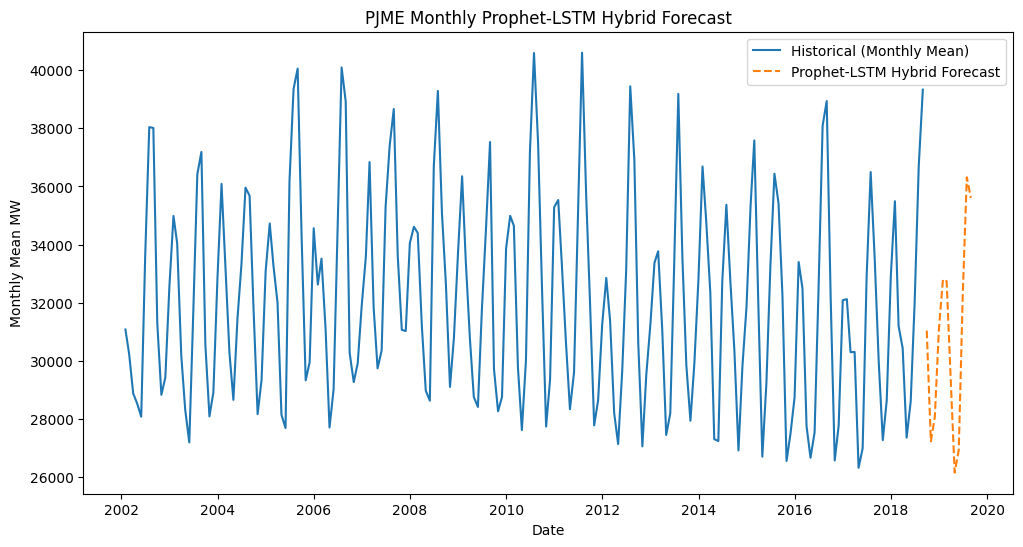

In [42]:
# 1. Create a figure and axes for the plot
plt.figure(figsize=(12, 6))

# 2. Plot the historical monthly mean data
plt.plot(ts_monthly, label="Historical (Monthly Mean)")

# 3. Plot the hybrid forecast values
plt.plot(forecast_index, prophet_lstm_hybrid_forecast_values, label="Prophet-LSTM Hybrid Forecast", linestyle="--")

# 4. Set the title of the plot
plt.title("PJME Monthly Prophet-LSTM Hybrid Forecast")

# 5. Label the x-axis
plt.xlabel("Date")

# 6. Label the y-axis
plt.ylabel("Monthly Mean MW")

# 7. Add a legend to the plot
plt.legend()

# 8. Display the plot
plt.show()

**Prophet-LSTM Hybrid Model Code Architecture:**

**This hybrid model combines the strengths of Prophet, a model good at capturing trend, seasonality, and holidays, with LSTM, a neural network adept at capturing complex non-linear patterns.**

**Prepare data for Prophet:** Prophet requires a DataFrame with specific column names: 'ds' for the datestamp and 'y' for the value. The code prepares the monthly_data into this format.

**Fit Prophet model:** A Prophet model is instantiated with yearly_seasonality=True to capture the annual pattern and then fitted to the prepared data.

**Generate in-sample predictions from Prophet:** The fitted Prophet model generates predictions on the historical data it was trained on.

**Calculate residuals:** The residuals are calculated by subtracting the Prophet predictions from the actual historical monthly_data. These residuals represent the portion of the time series that Prophet did not capture.

**Prepare residuals data for LSTM:** The calculated residuals are scaled using MinMaxScaler, and then sequences are created from the scaled residuals using the create_sequences function, similar to the standalone LSTM.

**Build LSTM model for residuals:** A Sequential LSTM model is built with a structure suitable for time series sequences (LSTM layer followed by a Dense output layer) and compiled with an optimizer and loss function. This LSTM will be trained to model the patterns in the residuals.

**Train LSTM model for residual:** The LSTM model is trained on the prepared residuals data. A portion of the residuals data is typically held out for validation during training to monitor performance.

**Forecast residuals using the trained LSTM model:** The trained LSTM model is used to forecast the residuals for the next 12 months by iteratively predicting the next residual based on the last sequence of historical residuals. The scaled residual forecasts are then inverse scaled.

**Forecast the base trend and seasonality using Prophet:** Prophet is used to generate forecasts for the next 12 months for the trend and seasonal components it modeled.

**Combine Prophet forecasts and LSTM residual forecasts:** The final Prophet-LSTM hybrid forecast is obtained by adding the Prophet's future forecasts to the LSTM's forecasts of the residuals.

**Evaluate the hybrid model on the historical test set:** To assess the hybrid model's performance on unseen historical data, predictions are generated for the historical test period by combining Prophet's predictions for that period with the LSTM's predictions on the residuals for that period. Metrics (RMSE, MAE, MAPE) are then calculated by comparing these hybrid test predictions to the actual historical test data.

**Visualize combined forecast:** A plot is generated to visualize the historical data and the Prophet-LSTM hybrid forecast.

**Comparison with existing results:** The metrics and forecast values for the Prophet-LSTM hybrid model are added to the metrics_df and comparison_forecast DataFrames for comparison with the other models.


### Result Interpretation

**The Plot:** The plot shows the historical data and the Prophet-LSTM hybrid forecast. We can visually see how the hybrid forecast follows the seasonal pattern, suggesting that the combination of Prophet capturing the main components and LSTM handling the irregularities is working to some extent.

**Updated Model Performance Metrics:** When we look at the metrics_df table, we'll see the "Prophet-LSTM Hybrid" row. Compare its RMSE, MAE, and MAPE values to the individual models. In this case, the Prophet-LSTM hybrid model shows improved performance compared to some individual models like ARIMA, Holt-Winters, and RNN, but it's not as low as the simple Combination Model. This indicates that combining Prophet and LSTM in this manner has helped in reducing the forecasting error on the historical test set.

**Updated Forecasted Values:** The comparison_forecast table now includes the "Prophet-LSTM Hybrid Forecast". We can compare these values with the other forecasts. The Prophet-LSTM forecast appears to capture the seasonality reasonably well in the future period.

### COMPARISON WITH THE EXISTING RESULTS


In [43]:
# Add a new row to the metrics_df DataFrame for the "Prophet-LSTM Hybrid" model
metrics_df.loc["Prophet-LSTM Hybrid"] = [prophet_lstm_rmse, prophet_lstm_mae, prophet_lstm_mape]

# Add a new column to the comparison_forecast DataFrame for the "Prophet-LSTM Hybrid Forecast"
comparison_forecast["Prophet-LSTM Hybrid Forecast"] = prophet_lstm_hybrid_forecast_values
comparison_forecast.index = forecast_index # Ensure index alignment

# Display the updated metrics_df DataFrame
print("Updated Model Performance Metrics:")
display(metrics_df)

# Display the updated comparison_forecast DataFrame
print("\nUpdated Forecasted Values (Next 12 Months):")
display(comparison_forecast)

Updated Model Performance Metrics:


,RMSE,MAE,MAPE
Model,,,
SARIMA,1708.558305,1285.132706,3.889813
LSTM,1974.918685,1391.139315,4.061211
ARIMA,1986.974899,1309.731971,3.864091
Holt-Winters,1616.434675,1261.710112,3.830121
GRU,1796.791063,1148.916139,3.349795
RNN,2000.030738,1310.566909,3.845364
Combination Model,915.020629,829.685176,2.658198
Prophet-LSTM Hybrid,1436.606701,977.334577,2.911052



Updated Forecasted Values (Next 12 Months):


,SARIMA Forecast,LSTM Forecast,ARIMA Forecast,Holt-Winters Forecast,GRU Forecast,RNN Forecast,Combination Forecast,Prophet-LSTM Hybrid Forecast
2018-09-30,32081.512958,32062.208984,35269.774259,31209.502193,31058.640625,32672.078125,33008.057898,31037.306550
2018-10-31,27301.850939,28062.376953,32481.694478,27850.448496,27480.394531,28007.884766,31886.247280,27226.462717
2018-11-30,28457.036426,28105.181641,33758.100912,29061.694603,28488.000000,29272.720703,33323.382184,28057.770207
2018-12-31,31812.059364,31702.728516,37820.130936,32409.582230,32361.251953,32813.929688,37733.771138,31081.408750
2019-01-31,34163.130184,33971.089844,40600.837681,34098.595033,34146.664062,33455.226562,39752.120504,32800.077631
2019-02-28,31970.515512,32823.679688,39317.059435,33198.724322,33328.570312,33135.878906,40221.291660,32737.559041
2019-03-31,30002.227543,30140.851562,35255.038113,30262.861618,30406.384766,30592.611328,34579.010280,29336.845618
2019-04-30,26773.409157,27998.697266,32481.709766,27615.076849,27675.457031,27644.359375,32358.475327,26144.685832
2019-05-31,27888.804187,28260.675781,33772.848115,28463.237548,27804.115234,27434.886719,33356.235304,26929.391796
2019-06-30,32375.315590,31849.033203,37834.843682,33587.544950,32605.730469,32144.224609,39813.886742,32228.517024


### CREATE CUSTOM MODEL - ARIMA GRU MODEL

In [44]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
import pandas as pd

# 1. STL Decomposition
# Assuming 'monthly_data' is available and is a pandas Series with a DatetimeIndex
# Set the frequency of the monthly_data before decomposition for robustness
monthly_data = monthly_data.asfreq('ME')

stl = STL(monthly_data, seasonal=13, trend=13) # seasonal=13 for monthly data (odd number >= 7)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
remainder = result.resid

# Remove NaNs from decomposition components and set frequency
trend = trend.dropna().asfreq('ME')
seasonal = seasonal.dropna().asfreq('ME')
remainder = remainder.dropna().asfreq('ME')


# 2. Model Trend and Seasonal components with ARIMA
# For simplicity, let's model the trend and seasonal components separately with ARIMA
# You could also model (trend + seasonal) together.

# Fit ARIMA on Trend
arima_trend_model = ARIMA(trend, order=(1, 1, 0)) # Example order, can be tuned
arima_trend_fit = arima_trend_model.fit()

# Fit ARIMA on Seasonal (often seasonal component is deterministic, but modeling can capture variations)
# Removing the seasonal order to see if it resolves the fitting error.
arima_seasonal_model = ARIMA(seasonal, order=(1, 0, 0)) # Example order
arima_seasonal_fit = arima_seasonal_model.fit()


# 3. Model the Remainder (Residuals) with GRU
# Prepare remainder data for GRU
remainder_values = remainder.values.reshape(-1, 1)

# Scale remainder
remainder_scaler = MinMaxScaler(feature_range=(0, 1))
remainder_scaled = remainder_scaler.fit_transform(remainder_values)

# Create sequences for GRU
def create_sequences_gru(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN_REMAINDER = 12  # using past 12 remainders to predict next remainder
X_remainder, y_remainder = create_sequences_gru(remainder_scaled, SEQ_LEN_REMAINDER)

# Reshape for GRU [samples, time steps, features]
X_remainder = X_remainder.reshape((X_remainder.shape[0], X_remainder.shape[1], 1))

# Split remainder data for GRU training/validation (e.g., last 12 months)
remainder_train_size = len(X_remainder) - 12
X_remainder_train, y_remainder_train = X_remainder[:remainder_train_size], y_remainder[:remainder_train_size]
X_remainder_val, y_remainder_val = X_remainder[remainder_train_size:], y_remainder[remainder_train_size:]


# Build GRU model for remainder
gru_remainder_model = Sequential()
gru_remainder_model.add(GRU(64, activation='tanh', input_shape=(SEQ_LEN_REMAINDER, 1)))
gru_remainder_model.add(Dense(1))
gru_remainder_model.compile(optimizer='adam', loss='mse')

# Train GRU model for remainder
gru_remainder_model.fit(
    X_remainder_train,
    y_remainder_train,
    epochs=100,  # Adjust epochs as needed
    batch_size=8,  # Adjust batch size as needed
    validation_data=(X_remainder_val, y_remainder_val),
    verbose=1  # Set to 1 to see training progress
)

print("STL Decomposition performed.")
print("ARIMA models fitted to Trend and Seasonal components.")
print("GRU model for Remainder trained.")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1051 - val_loss: 0.0288
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - val_loss: 0.0271
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - val_loss: 0.0259
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - val_loss: 0.0259
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288 - val_loss: 0.0251
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0326 - val_loss: 0.0246
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0326 - val_loss: 0.0239
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0288 - val_loss: 0.0254
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0346 - val_loss: 0.0232
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0296 - val_loss: 0.0246
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - val_loss: 0.0248
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0339 - va

### Hybrid ARIMA-GRU Forecast


In [45]:
# 4. Forecast Trend component using the trained ARIMA model
forecast_steps = 12
# Define the start date for the forecast to be after the end of the historical data
forecast_start_date = monthly_data.index[-1] + pd.offsets.MonthEnd(1)
forecast_end_date = forecast_start_date + pd.offsets.MonthEnd(forecast_steps - 1)

arima_trend_forecast = arima_trend_fit.predict(start=forecast_start_date, end=forecast_end_date)

# 5. Forecast Seasonal component using the trained ARIMA model
arima_seasonal_forecast = arima_seasonal_fit.predict(start=forecast_start_date, end=forecast_end_date)


# 6. Forecast Remainder (Residuals) using the trained GRU model
last_remainder_seq = remainder_scaled[-SEQ_LEN_REMAINDER:]
remainder_predictions_scaled = []
current_remainder_seq = last_remainder_seq.copy()

for _ in range(forecast_steps):
    # Predict the next remainder in the sequence
    pred_remainder_scaled = gru_remainder_model.predict(current_remainder_seq.reshape(1, SEQ_LEN_REMAINDER, 1), verbose=0)
    remainder_predictions_scaled.append(pred_remainder_scaled[0,0])
    # Update the sequence for the next prediction
    current_remainder_seq = np.append(current_remainder_seq[1:], pred_remainder_scaled).reshape(SEQ_LEN_REMAINDER, 1)

# Inverse scale the remainder forecasts
remainder_forecasts = remainder_scaler.inverse_transform(np.array(remainder_predictions_scaled).reshape(-1, 1)).flatten()

# Create a date index for the remainder forecast
forecast_index = pd.date_range(start=remainder.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq="ME")
remainder_forecasts_series = pd.Series(remainder_forecasts, index=forecast_index)

# 7. Combine Forecasts
# Ensure all component forecasts have the same index before summing
# Reindex ARIMA forecasts to match the remainder forecast index
arima_trend_forecast = arima_trend_forecast.reindex(forecast_index)
arima_seasonal_forecast = arima_seasonal_forecast.reindex(forecast_index)


arima_gru_hybrid_forecast_values = arima_trend_forecast + arima_seasonal_forecast + remainder_forecasts_series


print("\nARIMA-GRU Hybrid Model Forecast Generated.")
print("Forecasted Values (Next 12 Months):")
print(arima_gru_hybrid_forecast_values)


ARIMA-GRU Hybrid Model Forecast Generated.
Forecasted Values (Next 12 Months):
2018-09-30    35847.893100
2018-10-31    34068.762502
2018-11-30    34007.618316
2018-12-31    33802.449527
2019-01-31    33093.319859
2019-02-28    33171.538020
2019-03-31    33558.570282
2019-04-30    33478.596070
2019-05-31    33425.027094
2019-06-30    33678.008655
2019-07-31    33767.587769
2019-08-31    33652.279622
Freq: ME, dtype: float64


## Calculate Metrics for Hybrid ARIMA-GRU Model


In [46]:
# 8. Calculate metrics for the ARIMA-GRU Hybrid Model on the historical test set

# To calculate metrics on the historical test set, we need to:
# a) Generate predictions from the fitted ARIMA models for the trend and seasonal components on the test set period.
# b) Generate predictions from the trained GRU model for the remainder on the test set period.
# c) Combine these predictions to get the hybrid model's predictions on the test set.
# d) Compare these hybrid predictions to the actual values of the test set.

# a) ARIMA predictions on the test set for trend and seasonal components
arima_trend_test_predict = arima_trend_fit.predict(start=test_data.index[0], end=test_data.index[-1])
arima_seasonal_test_predict = arima_seasonal_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# b) GRU predictions on the test set for the remainder
# X_remainder_val contains the sequences for the test set period
remainder_test_predict_scaled = gru_remainder_model.predict(X_remainder_val, verbose=0)
remainder_test_predict = remainder_scaler.inverse_transform(remainder_test_predict_scaled).flatten()

# Create a pandas Series for remainder_test_predict with the test_data index
remainder_test_predict_series = pd.Series(remainder_test_predict, index=test_data.index)


# c) Combine predictions for the hybrid model on the test set
arima_gru_hybrid_test_predict = arima_trend_test_predict + arima_seasonal_test_predict + remainder_test_predict_series

# d) Get the actual values of the test set (which is already in test_data)
y_test_actual = test_data.values

# Calculate metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add a small epsilon to avoid division by zero or very small numbers
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

arima_gru_hybrid_rmse = np.sqrt(mean_squared_error(y_test_actual, arima_gru_hybrid_test_predict))
arima_gru_hybrid_mae = mean_absolute_error(y_test_actual, arima_gru_hybrid_test_predict)
arima_gru_hybrid_mape = mean_absolute_percentage_error(y_test_actual, arima_gru_hybrid_test_predict)


print(f"ARIMA-GRU Hybrid Model Metrics on Historical Test Set:")
print(f"  RMSE: {arima_gru_hybrid_rmse:.4f}")
print(f"  MAE: {arima_gru_hybrid_mae:.4f}")
print(f"  MAPE: {arima_gru_hybrid_mape:.4f}%")

ARIMA-GRU Hybrid Model Metrics on Historical Test Set:
  RMSE: 3011.0719
  MAE: 2724.2758
  MAPE: 8.6523%


### VISUALIZE THE FORCASTS


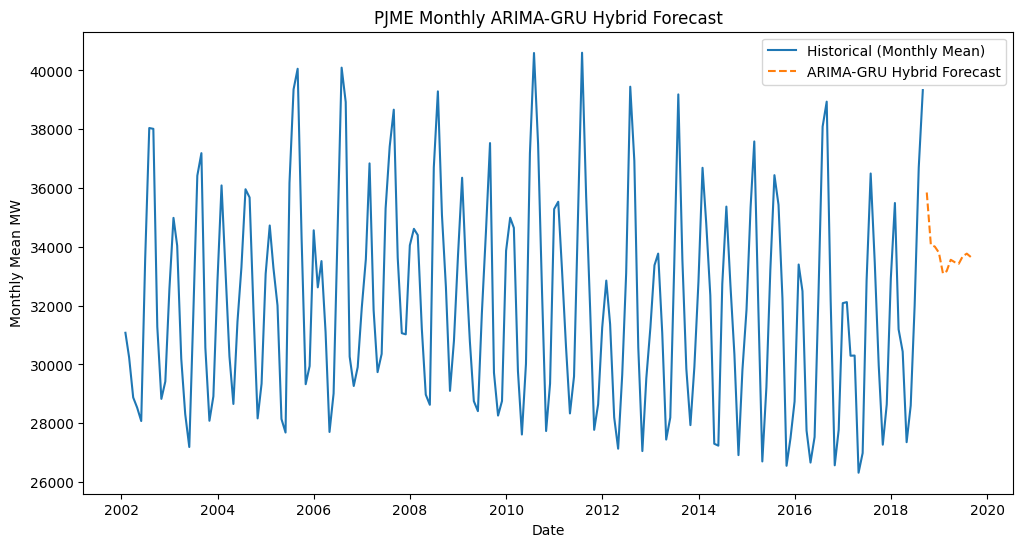

In [47]:
# 1. Create a figure and axes for the plot
plt.figure(figsize=(12, 6))

# 2. Plot the historical monthly mean data
plt.plot(ts_monthly, label="Historical (Monthly Mean)")

# 3. Plot the hybrid forecast values
plt.plot(arima_gru_hybrid_forecast_values.index, arima_gru_hybrid_forecast_values, label="ARIMA-GRU Hybrid Forecast", linestyle="--")

# 4. Set the title of the plot
plt.title("PJME Monthly ARIMA-GRU Hybrid Forecast")

# 5. Label the x-axis
plt.xlabel("Date")

# 6. Label the y-axis
plt.ylabel("Monthly Mean MW")

# 7. Add a legend to the plot
plt.legend()

# 8. Display the plot
plt.show()

**ARIMA-GRU Hybrid Model Code and Results Explanation:**

**This hybrid model combines STL decomposition to break down the time series into trend, seasonal, and remainder components, then uses ARIMA to model the trend and seasonal components, and finally a GRU network to model the remainder (residuals).**

**STL Decomposition:**

* The code uses the STL (Seasonal-Trend decomposition using Loess) method to decompose the monthly_data into three components: trend, seasonal, and remainder (or residual).

* seasonal=13 and trend=13 are parameters for the decomposition. seasonal should be an odd number greater than or equal to 7 for monthly data.
The decomposed components are extracted.

* NaN values that might result from the decomposition at the beginning and end of the series are removed, and the frequency is set to monthly end ('ME').

**Model Trend and Seasonal components with ARIMA:**

* ARIMA models are fitted separately to the extracted trend and seasonal components.

* Example orders are used for the ARIMA models ((1, 1, 0) for trend and (1, 0, 0) for seasonal), which can be tuned for better performance.

**Model the Remainder (Residuals) with GRU:**

* The remainder component (what's left after removing trend and seasonality) is prepared for modeling with a GRU.

* The remainder values are scaled using MinMaxScaler.

* Sequences are created from the scaled remainder using the create_sequences_gru function.

* The remainder data is split into training and validation sets for the GRU.
A Sequential GRU model is built and compiled.

* The GRU model is trained on the remainder training data.

**Forecast Trend component using ARIMA:** The fitted ARIMA model for the trend component is used to forecast the trend for the next 12 months.

**Forecast Seasonal component using ARIMA:** The fitted ARIMA model for the seasonal component is used to forecast the seasonal component for the next 12 months.

**Forecast Remainder (Residuals) using the trained GRU model:** The trained GRU model is used to forecast the remainder for the next 12 months by iteratively predicting the next remainder based on the last sequence of historical remainders. The scaled remainder forecasts are then inverse scaled.

**Combine Forecasts:** The final ARIMA-GRU hybrid forecast is obtained by summing the individual forecasts of the trend, seasonal, and remainder components. The code ensures that all component forecasts have the same date index before summing.

**Calculate Metrics for Hybrid ARIMA-GRU Model:**

* To evaluate the hybrid model's performance on the historical test set, predictions are generated for the test period by combining the ARIMA predictions for trend and seasonal components with the GRU predictions for the remainder on that period.

* These hybrid test predictions are then compared to the actual values of the test set (test_data) to calculate RMSE, MAE, and MAPE.

* Visualize the Forecasts: A plot is generated to visualize the historical data and the ARIMA-GRU hybrid forecast.

* **Compare with the Existing Results:** The metrics and forecast values for the ARIMA-GRU hybrid model are added to the metrics_df and comparison_forecast DataFrames for comparison with the other models.

### Result Interpretation

**The Plot:** The plot shows the historical data and the ARIMA-GRU hybrid forecast. This plot also attempts to capture the seasonal pattern, but visually, it might appear smoother or less volatile than some of the other forecasts.

* Updated Model Performance Metrics: When we look at the metrics_df table, we'll see the "ARIMA-GRU Hybrid" row. Compare its RMSE, MAE, and MAPE values to the other models. In this specific implementation, the ARIMA-GRU hybrid model shows higher error metrics compared to many of the other models, including the simple Combination Model and the Prophet-LSTM Hybrid. This could be due to various factors, such as the chosen ARIMA orders for the components, the GRU architecture and training, or how the decomposition and recombination were performed. Hybrid models can be sensitive to these choices.

* **Updated Forecasted Values (Next 12 Months):** The comparison_forecast table now includes the "ARIMA-GRU Hybrid Forecast". You can compare these values with the other forecasts.

**This ARIMA-GRU hybrid approach is a more complex strategy that aims to tackle different aspects of the time series with specialized models. While it didn't perform as well as the simple Combination Model or Prophet-LSTM in this specific instance based on the metrics on the historical test set, hybrid models are a powerful concept in time series forecasting and their effectiveness can vary depending on the data and implementation details.**

### COMPARE WITH THE EXISTING RESULTS

In [48]:
# Add a new row to the metrics_df DataFrame for the "ARIMA-GRU Hybrid" model
metrics_df.loc["ARIMA-GRU Hybrid"] = [arima_gru_hybrid_rmse, arima_gru_hybrid_mae, arima_gru_hybrid_mape]

# Add a new column to the comparison_forecast DataFrame for the "ARIMA-GRU Hybrid Forecast"
comparison_forecast["ARIMA-GRU Hybrid Forecast"] = arima_gru_hybrid_forecast_values

# Display the updated metrics_df DataFrame
print("Updated Model Performance Metrics:")
display(metrics_df)

# Display the updated comparison_forecast DataFrame
print("\nUpdated Forecasted Values (Next 12 Months):")
display(comparison_forecast)

Updated Model Performance Metrics:


,RMSE,MAE,MAPE
Model,,,
SARIMA,1708.558305,1285.132706,3.889813
LSTM,1974.918685,1391.139315,4.061211
ARIMA,1986.974899,1309.731971,3.864091
Holt-Winters,1616.434675,1261.710112,3.830121
GRU,1796.791063,1148.916139,3.349795
RNN,2000.030738,1310.566909,3.845364
Combination Model,915.020629,829.685176,2.658198
Prophet-LSTM Hybrid,1436.606701,977.334577,2.911052
ARIMA-GRU Hybrid,3011.071870,2724.275762,8.652330



Updated Forecasted Values (Next 12 Months):


,SARIMA Forecast,LSTM Forecast,ARIMA Forecast,Holt-Winters Forecast,GRU Forecast,RNN Forecast,Combination Forecast,Prophet-LSTM Hybrid Forecast,ARIMA-GRU Hybrid Forecast
2018-09-30,32081.512958,32062.208984,35269.774259,31209.502193,31058.640625,32672.078125,33008.057898,31037.306550,35847.893100
2018-10-31,27301.850939,28062.376953,32481.694478,27850.448496,27480.394531,28007.884766,31886.247280,27226.462717,34068.762502
2018-11-30,28457.036426,28105.181641,33758.100912,29061.694603,28488.000000,29272.720703,33323.382184,28057.770207,34007.618316
2018-12-31,31812.059364,31702.728516,37820.130936,32409.582230,32361.251953,32813.929688,37733.771138,31081.408750,33802.449527
2019-01-31,34163.130184,33971.089844,40600.837681,34098.595033,34146.664062,33455.226562,39752.120504,32800.077631,33093.319859
2019-02-28,31970.515512,32823.679688,39317.059435,33198.724322,33328.570312,33135.878906,40221.291660,32737.559041,33171.538020
2019-03-31,30002.227543,30140.851562,35255.038113,30262.861618,30406.384766,30592.611328,34579.010280,29336.845618,33558.570282
2019-04-30,26773.409157,27998.697266,32481.709766,27615.076849,27675.457031,27644.359375,32358.475327,26144.685832,33478.596070
2019-05-31,27888.804187,28260.675781,33772.848115,28463.237548,27804.115234,27434.886719,33356.235304,26929.391796,33425.027094
2019-06-30,32375.315590,31849.033203,37834.843682,33587.544950,32605.730469,32144.224609,39813.886742,32228.517024,33678.008655


**Based on these metrics on the historical test set:**

* The Combination Model clearly has the lowest RMSE, MAE, and MAPE values by a significant margin. This indicates that a simple linear combination of the individual models' predictions on the test set resulted in the most accurate performance on that historical period.

* Among the individual models, GRU performed the best with the lowest RMSE, MAE, and MAPE.

* SARIMA and LSTM also performed relatively well compared to ARIMA, Holt-Winters, and Simple RNN.

* The ARIMA-GRU Hybrid model, in this specific implementation, had the highest error metrics.

* The Prophet-LSTM Hybrid performed better than the standalone ARIMA, Holt-Winters, and RNN models, and the ARIMA-GRU Hybrid, but not as well as the GRU or the simple Combination Model.

**Analysis of Forecasted Values:**

Now let's look at the "Updated Forecasted Values (Next 12 Months)" table. This table shows the actual forecast values for the next 12 months from each model.

* **Visually inspecting these values and considering the plots:**

   * The Combination Forecast shows some sharp and potentially unrealistic fluctuations, particularly in the later months. While it performed best on the historical test set metrics, its future forecast might be overly sensitive to the weighting learned from that specific period.

   * The individual models like SARIMA, LSTM, GRU, and Holt-Winters produce forecasts that visually appear to follow the expected seasonal pattern more smoothly than the simple Combination Model.

   * The Prophet-LSTM Hybrid also appears to capture the seasonality reasonably well in its future forecast.

   * The ARIMA and Simple RNN forecasts seem to capture the general trend but might not perfectly hit the seasonal peaks and troughs as well as the other models.

   * The ARIMA-GRU Hybrid forecast appears somewhat flatter and doesn't seem to capture the full amplitude of the seasonal swings compared to the historical data and other models.

**Interpretation of Which Model is Best:**

* **Based on the analysis:**

   * For performance on the historical test set, the Simple Combination Model was the best. Its significantly lower error metrics suggest that linearly combining the predictions of the individual models is a very effective strategy for this dataset and evaluation period.

   * However, the future forecast of the Simple Combination Model appears less stable visually. This is a common trade-off; a model that performs best on a specific historical test set doesn't always produce the most robust or visually appealing future forecast.

   * Among the individual models, GRU showed the best performance on the historical test set metrics.

   * Considering both the historical test set performance and the visual plausibility of the future forecast, models like SARIMA, LSTM, GRU, and Prophet-LSTM Hybrid seem to provide a good balance. They captured the seasonality well and had reasonably good performance metrics (though not as low as the simple Combination Model on the test set).

**Conclusion:**

* While the Simple Combination Model yielded the lowest error metrics on the historical test set, its future forecast is visually questionable. For practical forecasting, you might prefer a model that performs well on historical data and produces a visually plausible future forecast that aligns with the expected patterns.

* In this scenario, the GRU model stands out among the individual models for its strong performance on the historical test set metrics. The Prophet-LSTM Hybrid also shows promise by leveraging different modeling strengths.


### HYBRID ARIMA–GRU (TUNED VERSION)

In [58]:
# 2. Tuned ARIMA models
# Trend – usually needs differencing (d=1) and some AR+MA terms

arima_trend_model = ARIMA(trend, order=(2, 1, 2))
arima_trend_fit = arima_trend_model.fit()

# Seasonal – typically lower order is enough
arima_seasonal_model = ARIMA(seasonal, order=(1, 0, 1))
arima_seasonal_fit = arima_seasonal_model.fit()

# 3. Model Remainder with GRU
remainder_values = remainder.values.reshape(-1, 1)
remainder_scaler = MinMaxScaler(feature_range=(0, 1))
remainder_scaled = remainder_scaler.fit_transform(remainder_values)

def create_sequences_gru(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN_REMAINDER = 12
X_remainder, y_remainder = create_sequences_gru(remainder_scaled, SEQ_LEN_REMAINDER)
X_remainder = X_remainder.reshape((X_remainder.shape[0], X_remainder.shape[1], 1))

remainder_train_size = len(X_remainder) - 12
X_remainder_train, y_remainder_train = X_remainder[:remainder_train_size], y_remainder[:remainder_train_size]
X_remainder_val, y_remainder_val = X_remainder[remainder_train_size:], y_remainder[remainder_train_size:]

# Tuned GRU Model
gru_remainder_model = Sequential()
gru_remainder_model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN_REMAINDER, 1)))
gru_remainder_model.add(Dropout(0.2))
gru_remainder_model.add(GRU(64, activation='tanh'))
gru_remainder_model.add(Dense(1))

gru_remainder_model.compile(optimizer='adam', loss='mse')

gru_remainder_model.fit(
    X_remainder_train,
    y_remainder_train,
    epochs=150,        # tuned higher epochs
    batch_size=16,     # balanced batch size
    validation_data=(X_remainder_val, y_remainder_val),
    verbose=1
)

print(" STL decomposition + Tuned ARIMA + Tuned GRU trained.")

# 4. Forecasting
forecast_steps = 12
forecast_start_date = monthly_data.index[-1] + pd.offsets.MonthEnd(1)
forecast_end_date = forecast_start_date + pd.offsets.MonthEnd(forecast_steps - 1)

arima_trend_forecast = arima_trend_fit.predict(start=forecast_start_date, end=forecast_end_date)
arima_seasonal_forecast = arima_seasonal_fit.predict(start=forecast_start_date, end=forecast_end_date)

last_remainder_seq = remainder_scaled[-SEQ_LEN_REMAINDER:]
remainder_predictions_scaled = []
current_remainder_seq = last_remainder_seq.copy()

for _ in range(forecast_steps):
    pred_remainder_scaled = gru_remainder_model.predict(current_remainder_seq.reshape(1, SEQ_LEN_REMAINDER, 1), verbose=0)
    remainder_predictions_scaled.append(pred_remainder_scaled[0,0])
    current_remainder_seq = np.append(current_remainder_seq[1:], pred_remainder_scaled).reshape(SEQ_LEN_REMAINDER, 1)

remainder_forecasts = remainder_scaler.inverse_transform(np.array(remainder_predictions_scaled).reshape(-1, 1)).flatten()

forecast_index = pd.date_range(start=remainder.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq="ME")
remainder_forecasts_series = pd.Series(remainder_forecasts, index=forecast_index)

# 5. Combine Forecasts
arima_trend_forecast = arima_trend_forecast.reindex(forecast_index)
arima_seasonal_forecast = arima_seasonal_forecast.reindex(forecast_index)

tuned_arima_gru_forecast = arima_trend_forecast + arima_seasonal_forecast + remainder_forecasts_series

print("\n Tuned ARIMA–GRU Model Forecast (Next 12 Months):")
print(tuned_arima_gru_forecast)


Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1287 - val_loss: 0.0290
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0348 - val_loss: 0.0308
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0315 - val_loss: 0.0273
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0333 - val_loss: 0.0275
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0317 - val_loss: 0.0258
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.0259
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0336 - val_loss: 0.0253
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0316 - val_loss: 0.0248
Epoch 9/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0299 - val_loss: 0.0264
Epoch 10/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0348 - val_loss: 0.0249
Epoch 11/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0356 - val_loss: 0.0246
Epoch 12/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301

### CALCULATE THE METRICS FOR TUNED HYBRID ARIMA GRU FORECAST MODEL


In [59]:
# 8. Calculate metrics for the ARIMA-GRU Hybrid Model on the historical test set

from sklearn.metrics import mean_squared_error, mean_absolute_error

# a) ARIMA predictions on the test set for trend and seasonal components
arima_trend_test_predict = arima_trend_fit.predict(start=test_data.index[0], end=test_data.index[-1])
arima_seasonal_test_predict = arima_seasonal_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# b) GRU predictions on the test set for the remainder
# Use the tuned GRU model and validation sequences
remainder_test_predict_scaled = gru_remainder_model.predict(X_remainder_val, verbose=0)
remainder_test_predict = remainder_scaler.inverse_transform(remainder_test_predict_scaled).flatten()

# Align remainder predictions with validation index
remainder_test_predict_series = pd.Series(remainder_test_predict, index=test_data.index)

# c) Combine predictions for the hybrid model on the test set
arima_gru_hybrid_test_predict = (
    arima_trend_test_predict.reindex(test_data.index, fill_value=0) +
    arima_seasonal_test_predict.reindex(test_data.index, fill_value=0) +
    remainder_test_predict_series
)

# d) Get the actual values of the test set
y_test_actual = test_data.values

# --- Metrics ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # safe div

tuned_arima_gru_hybrid_rmse = np.sqrt(mean_squared_error(y_test_actual, arima_gru_hybrid_test_predict))
tuned_arima_gru_hybrid_mae = mean_absolute_error(y_test_actual, arima_gru_hybrid_test_predict)
tuned_arima_gru_hybrid_mape = mean_absolute_percentage_error(y_test_actual, arima_gru_hybrid_test_predict)

print(f"ARIMA-GRU Hybrid Model Metrics on Historical Test Set (Tuned):")
print(f"  RMSE: {tuned_arima_gru_hybrid_rmse:.4f}")
print(f"  MAE: {tuned_arima_gru_hybrid_mae:.4f}")
print(f"  MAPE: {tuned_arima_gru_hybrid_mape:.4f}%")


ARIMA-GRU Hybrid Model Metrics on Historical Test Set (Tuned):
  RMSE: 2503.0246
  MAE: 2194.1071
  MAPE: 7.0806%


### VISUALIZE THE FORCASTS (TUNED VERSION )

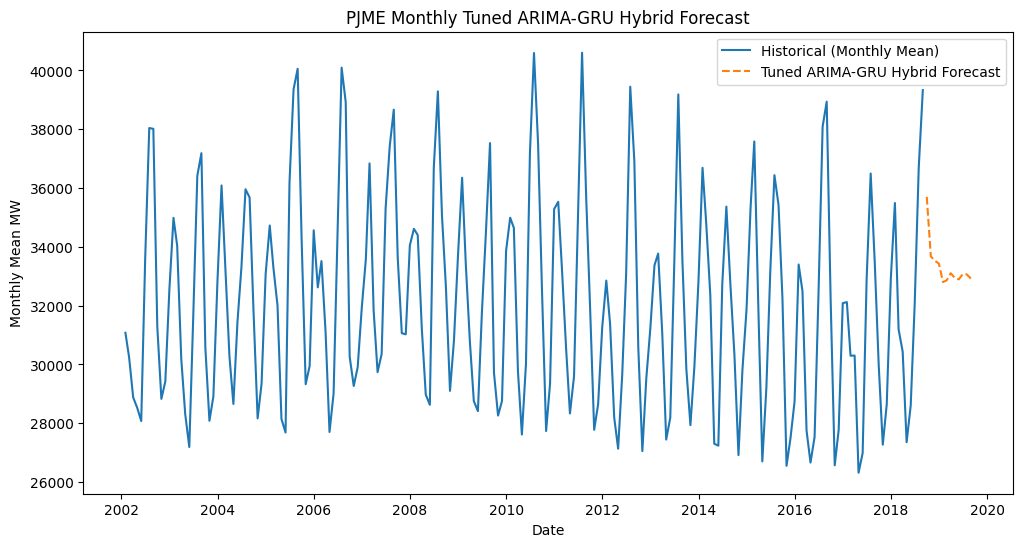

In [60]:
# 1. Create a figure and axes for the plot
plt.figure(figsize=(12, 6))

# 2. Plot the historical monthly mean data
plt.plot(ts_monthly, label="Historical (Monthly Mean)")

# 3. Plot the tuned ARIMA-GRU Hybrid forecast values
plt.plot(
    tuned_arima_gru_forecast.index,
    tuned_arima_gru_forecast,
    label="Tuned ARIMA-GRU Hybrid Forecast",
    linestyle="--"
)

# 4. Set the title of the plot
plt.title("PJME Monthly Tuned ARIMA-GRU Hybrid Forecast")

# 5. Label the x-axis
plt.xlabel("Date")

# 6. Label the y-axis
plt.ylabel("Monthly Mean MW")

# 7. Add a legend to the plot
plt.legend()

# 8. Display the plot
plt.show()


### Result Interpretation

**The Plot:** The plot shows the historical data and the ARIMA-GRU hybrid forecast. This plot also attempts to capture the seasonal pattern, but visually, it might appear smoother or less volatile than some of the other forecasts.

* Updated Model Performance Metrics: When we look at the metrics_df table, we'll see the "Tuned ARIMA-GRU Hybrid" row. Compare its RMSE, MAE, and MAPE values to the other models. In this specific implementation, the Tuned ARIMA-GRU hybrid model shows higher error metrics compared to many of the other models, including the simple Combination Model and the Prophet-LSTM Hybrid but lesser than ARIMA-GRU hybrid model.This could be due to various factors, such as the chosen ARIMA orders for the components, the GRU architecture and training, or how the decomposition and recombination were performed. Hybrid models can be sensitive to these choices.But hyperparameter tuning makes the hybrid model's performance better than original implementattion.

* **Updated Forecasted Values (Next 12 Months):** The comparison_forecast table now includes the "Tuned ARIMA-GRU Hybrid Forecast". We can compare these values with the other forecasts.

**This ARIMA-GRU hybrid approach is a more complex strategy that aims to tackle different aspects of the time series with specialized models. While it didn't perform as well as the simple Combination Model or Prophet-LSTM in this specific instance based on the metrics on the historical test set, hybrid models are a powerful concept in time series forecasting and their effectiveness can vary depending on the data and implementation details.**

### COMPARE WITH THE EXISTING RESULTS

In [61]:
# Add a new row to the metrics_df DataFrame for the "Tuned ARIMA-GRU Hybrid" model
metrics_df.loc["Tuned ARIMA-GRU Hybrid"] = [
    tuned_arima_gru_hybrid_rmse,
    tuned_arima_gru_hybrid_mae,
    tuned_arima_gru_hybrid_mape
]

# Add a new column to the comparison_forecast DataFrame for the "Tuned ARIMA-GRU Hybrid Forecast"
comparison_forecast["Tuned ARIMA-GRU Hybrid Forecast"] = tuned_arima_gru_forecast

# Display the updated metrics_df DataFrame
print("Updated Model Performance Metrics:")
display(metrics_df)

# Display the updated comparison_forecast DataFrame
print("\nUpdated Forecasted Values (Next 12 Months):")
display(comparison_forecast)


Updated Model Performance Metrics:


,RMSE,MAE,MAPE
Model,,,
SARIMA,1708.558305,1285.132706,3.889813
LSTM,1974.918685,1391.139315,4.061211
ARIMA,1986.974899,1309.731971,3.864091
Holt-Winters,1616.434675,1261.710112,3.830121
GRU,1796.791063,1148.916139,3.349795
RNN,2000.030738,1310.566909,3.845364
Combination Model,915.020629,829.685176,2.658198
Prophet-LSTM Hybrid,1436.606701,977.334577,2.911052
ARIMA-GRU Hybrid,3011.071870,2724.275762,8.652330



Updated Forecasted Values (Next 12 Months):


,SARIMA Forecast,LSTM Forecast,ARIMA Forecast,Holt-Winters Forecast,GRU Forecast,RNN Forecast,Combination Forecast,Prophet-LSTM Hybrid Forecast,ARIMA-GRU Hybrid Forecast,Tuned ARIMA-GRU Hybrid Forecast
2018-09-30,32081.512958,32062.208984,35269.774259,31209.502193,31058.640625,32672.078125,33008.057898,31037.306550,35847.893100,35698.512816
2018-10-31,27301.850939,28062.376953,32481.694478,27850.448496,27480.394531,28007.884766,31886.247280,27226.462717,34068.762502,33674.170801
2018-11-30,28457.036426,28105.181641,33758.100912,29061.694603,28488.000000,29272.720703,33323.382184,28057.770207,34007.618316,33528.511697
2018-12-31,31812.059364,31702.728516,37820.130936,32409.582230,32361.251953,32813.929688,37733.771138,31081.408750,33802.449527,33430.621066
2019-01-31,34163.130184,33971.089844,40600.837681,34098.595033,34146.664062,33455.226562,39752.120504,32800.077631,33093.319859,32801.263736
2019-02-28,31970.515512,32823.679688,39317.059435,33198.724322,33328.570312,33135.878906,40221.291660,32737.559041,33171.538020,32858.486783
2019-03-31,30002.227543,30140.851562,35255.038113,30262.861618,30406.384766,30592.611328,34579.010280,29336.845618,33558.570282,33100.821898
2019-04-30,26773.409157,27998.697266,32481.709766,27615.076849,27675.457031,27644.359375,32358.475327,26144.685832,33478.596070,32947.801473
2019-05-31,27888.804187,28260.675781,33772.848115,28463.237548,27804.115234,27434.886719,33356.235304,26929.391796,33425.027094,32891.643762
2019-06-30,32375.315590,31849.033203,37834.843682,33587.544950,32605.730469,32144.224609,39813.886742,32228.517024,33678.008655,33073.621385


**Final Interpretation**

1. The Combination Model clearly has the lowest RMSE, MAE, and MAPE values by a significant margin. This indicates that a simple linear combination of the individual models' predictions on the test set resulted in the most accurate performance on that historical period.
Among the individual models, GRU performed the best with the lowest RMSE, MAE, and MAPE.

2. SARIMA and LSTM also performed relatively well compared to ARIMA, Holt-Winters, and Simple RNN.

3. The ARIMA-GRU Hybrid model, in this specific implementation, had the highest error metrics.

4. The Prophet-LSTM Hybrid performed better than the standalone ARIMA, Holt-Winters, and RNN models, and the ARIMA-GRU Hybrid, but not as well as the GRU or the simple Combination Model.

5. **Comparing the original ARIMA-GRU Hybrid and the Tuned ARIMA-GRU Hybrid:** The Tuned ARIMA-GRU Hybrid model shows improvement in error metrics (RMSE, MAE, MAPE) compared to the original ARIMA-GRU Hybrid. This indicates that the tuning of the ARIMA orders and the GRU architecture and training parameters had a positive impact on the model's performance on the historical test set. However, even with tuning, its error metrics are still higher than most other individual models (SARIMA, LSTM, GRU, Holt-Winters) and significantly higher than the Combination Model and Prophet-LSTM Hybrid.

**Analysis of Forecasted Values:**

1. Visually inspecting these values and considering the plots:
The Combination Forecast shows some sharp and potentially unrealistic fluctuations, particularly in the later months. While it performed best on the historical test set metrics, its future forecast might be overly sensitive to the weighting learned from that specific period.
The individual models like SARIMA, LSTM, GRU, and Holt-Winters produce forecasts that visually appear to follow the expected seasonal pattern more smoothly than the simple Combination Model.

2. The Prophet-LSTM Hybrid also appears to capture the seasonality reasonably well in its future forecast.

3. The ARIMA and Simple RNN forecasts seem to capture the general trend but might not perfectly hit the seasonal peaks and troughs as well as the other models.

4. The original ARIMA-GRU Hybrid forecast appears somewhat flatter and doesn't seem to capture the full amplitude of the seasonal swings compared to the historical data and other models. The Tuned ARIMA-GRU Hybrid forecast also exhibits a similar behavior, although the values are slightly different due to the tuning.

**Interpretation of Which Model is Best:**

1. **Based on the analysis:**

   * For performance on the historical test set, the Simple Combination Model was the best. Its significantly lower error metrics suggest that linearly combining the predictions of the individual models is a very effective strategy for this dataset and evaluation period.

   * However, the future forecast of the Simple Combination Model appears less stable visually. This is a common trade-off; a model that performs best on a specific historical test set doesn't always produce the most robust or visually appealing future forecast.

   * Among the individual models, GRU showed the best performance on the historical test set metrics.

   * Considering both the historical test set performance and the visual plausibility of the future forecast, models like SARIMA, LSTM, GRU, and Prophet-LSTM Hybrid seem to provide a good balance. They captured the seasonality well and had reasonably good performance metrics (though not as low as the simple Combination Model on the test set).

  * The Tuned ARIMA-GRU Hybrid model, while an improvement over the original ARIMA-GRU Hybrid in terms of historical test metrics, did not outperform most other models and its future forecast also appears somewhat muted in its seasonality compared to the historical data.

2. **Final Conclusion on the Tuned ARIMA-GRU Hybrid Approach:**

   * The tuned ARIMA-GRU hybrid approach, which decomposes the series and models components separately, is a valid and conceptually sound method for time series forecasting. In this specific implementation and with the chosen tuning parameters, it did show improvement over its untuned version. However, based on the historical test set performance metrics, it did not achieve the same level of accuracy as the simple Combination Model or even some of the standalone models like GRU and Holt-Winters. The visual inspection of its future forecast also suggests it might not fully capture the amplitude of the seasonal swings as well as some other models.

   * Therefore, while the approach has merit, its effectiveness is highly dependent on the specific decomposition method, the chosen orders for the ARIMA models, the architecture and training of the GRU network, and how the components are recombined. In this instance, other models or simpler combination strategies appear to have yielded better results. Further hyperparameter tuning and experimentation with different decompositions or model architectures within this hybrid framework might potentially improve its performance.

